# Module Load

In [587]:
import h5py, math, cmath, scipy, random, os, csv, pathlib, matplotlib

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy.optimize import curve_fit
from matplotlib import rcParams, rc, cm, colors
from sklearn.decomposition import PCA
from scipy.stats import skew, poisson, kurtosis 
from matplotlib.font_manager import FontProperties
from scipy.ndimage import gaussian_filter, median_filter, sobel
from scipy.interpolate import griddata
from scipy.signal.signaltools import wiener
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
from scipy.special import sph_harm, lambertw
from scipy import interpolate

import scipy.integrate as integrate
import matplotlib.tri as tri
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
import scipy.special as sp
import time as timeCheck

plt.style.use('classic')
%matplotlib inline
rcParams['font.family'] = 'Times New Roman'

if 0 : plt.style.use('ggplot')
if 0 : import seaborn as sns; sns.set()

rc('text', usetex=True)
rc('axes', linewidth=2)
rc('font', weight='bold')
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
 
path_local = str(pathlib.Path().absolute())
print('path_local = ',path_local)

path_local =  /Users/kwoo/Desktop/PostDoc/InitialPlasma/python


# Electron Collision Frequency

## get_param

In [1480]:
um = 10**-6 # m
nm = 10**-9 # m
ns = 10**-9 # s
ps = 10**-12 # s
fs = 10**-15 # s

mole = 6.02214076*10**23 # unitless, the Avogadro number
amu = 1.66*10**-27 # kg
angstorm = 10**-10 # m
hbar = 1.0545718*10**-34 # J*s
eV = 1.6*10**-19 # J
dyne = 10**-5 # N
massElectron = 9.10938356*10**-31 # kg
eCharge = 1.602176634*10**-19 # C
eCharge_ESU = 4.80326*10**-10 # esu
kB = 1.380649*10**-23 # J/K

lightSpeed = 299792458 # m/s
vacuumPermittivity = 8.854*10**-12 # C⋅V−1⋅m−1

wavelength_355nm = 355*nm # m
wavelength_450nm = 450*nm # m
omega_355nm = 2*np.pi*(lightSpeed/wavelength_355nm) # 1/s
omega_450nm = 2*np.pi*(lightSpeed/wavelength_450nm) # 1/s

meV = 0.001*eV # J
mdyne = 0.001*dyne # N
massElectronReduced = massElectron/2 # kg

gcm3_to_kgm3 = 1000 # kg/m^3
kelvin_to_eV = 8.621738*10**-5 # eV 
J_to_erg = 10**7 # erg
cm3_to_m3 = 0.01**3 # m^3
J_per_mole_per_K = 1/mole/kelvin_to_eV/eV

#################
# SI units
#################
Ti = 0.025*eV # J
Te = 0.025*eV # J
Tc = 58*meV   # J
rho = 1*gcm3_to_kgm3 # kg/m^3
#####################################################################
# Engineering ToolBox, (2004). Speed of Sound in Solids and Metals
# https://www.engineeringtoolbox.com/sound-speed-solids-d_713.html
cs = 2350 # m/s
#cs = 10414.838745062643 # dw/dk
#####################################################################
Upotential = 3.5*eV # J
mPh  = (12*6+5)*amu # kg
mCH  = (12*1+1)*amu # kg
mCH2 = (12*1+2)*amu # kg
mC8H8 = mPh + mCH + mCH2
dCC = 1.53*angstorm # m
a = 2*dCC         # m
G = 4.855*mdyne/angstorm # N/m
K = 4.000*mdyne/angstorm # N/m
kBZ = 2*np.pi/a # 1/m
kmin_EAP = massElectronReduced*cs/hbar # 1/m
#E_LO1 = 72.87*meV  # 33.53*meV # J
#E_LO2 = 192.80*meV # 88.73*meV # J
E_LO1 = 33.53*meV # J
E_LO2 = 88.73*meV # J
omega_LO1 = E_LO1/hbar # 1/s
omega_LO2 = E_LO2/hbar # 1/s
varepsilon_0     = 2.5
varepsilon_infty = 1.01
kmin_EOP_absrob = np.sqrt(E_LO1*10**-3*2*massElectronReduced)/hbar # 1/m
kmin_EOP_emit1  = np.sqrt(E_LO1*2*massElectronReduced)/hbar # 1/m
kmin_EOP_emit2  = np.sqrt(E_LO2*2*massElectronReduced)/hbar # 1/m
# mass_density/total_ion_mass*Z_total [1/cm^3]
R_CH = 1.03*1000 # kg/m^3
Z_CH = 7 # no unit
A_CH = (12.011+1.008)*1.66053904e-27 # kg
n_vb_CH = Z_CH*R_CH/A_CH # [1/m^3]
Eg_CH   = 4.05*eV # [J]
n_a_CH  = 1.02*10**23*100**3 # 1/m^3
Zmax_CH = Z_CH/2

## get_nc

In [19]:
def get_nc(wavelength):
    
    # input wavelength unit : m
    # output nc unit        : 1/m^3
    
    angular_freq = 2*math.pi*(lightSpeed/wavelength)
    ne_crit = vacuumPermittivity*massElectron*angular_freq**2/eCharge**2
    return ne_crit # (1/m^3)

nc_355nm = get_nc(wavelength_355nm) # 1/m^3
nc_450nm = get_nc(wavelength_450nm) # 1/m^3

## get_E_Fermi

In [560]:
def get_E_Fermi(ne):
    
    # https://en.wikipedia.org/wiki/Fermi_energy
    
    # ne : 1/m^3
    # massElectron : kg
    
    EF = hbar**2/(2*massElectron)*(3*np.pi**2*ne)**(2/3) # J
        
    return EF # J

E_Fermi_355nm = get_E_Fermi(ne=get_nc(wavelength_355nm))
E_Fermi_450nm = get_E_Fermi(ne=get_nc(wavelength_450nm))

print('E_Fermi_355nm/eV = ',"{:.3e}".format(E_Fermi_355nm/eV))
print('E_Fermi_450nm/eV = ',"{:.3e}".format(E_Fermi_450nm/eV))

E_Fermi_355nm/eV =  1.562e+00
E_Fermi_450nm/eV =  1.138e+00


## get_mu

In [925]:
def get_mu(ne,Te):
    
    #print('>>> get_mu ... ')  
    
    #To sum up, to increase the number of particles of a classical gas keeping the       volume and entropy constant, you have to change the energy of the system by a negative amount. This change in the energy (which is negative) is the chemical potential of the classical gas.
        
    # ne : 1/m^3
    # Te : J
    
    y = hbar**3*np.pi**2*ne/np.sqrt(2)/(massElectron*Te)**(3/2)
    
    a  = 15
    y0 = 1.52
    
    if y < 1 :        
        inside = 4*y/(2*np.pi**0.5-y)        
        mu = Te*np.log(inside)
        
    if (y >= 1) and (y<2.5) :
        inside1 = 4*y/(2*np.pi**0.5-y)
        inside2 = (3*y/2)**(4/3)-np.pi**2/6
        denominator1 = 1+math.exp( a*(y-y0))
        denominator2 = 1+math.exp(-a*(y-y0))        
        mu = Te*(np.log(inside1)/denominator1+np.sqrt(inside2)/denominator2)
        
    if y >= 2.5 :
        inside = (3*y/2)**(4/3)-np.pi**2/6
        mu = Te*np.sqrt(inside)
    
    #print('get_mu : mu = ',mu)
    #return mu/eV # eV
    return mu # J

#temp = [ T for T in np.arange(0.01,100,0.01)]
#mu = [get_mu(10**22*100**3,Te*eV)/eV for Te in temp]
#plt.plot(temp,mu)

## get_f_k

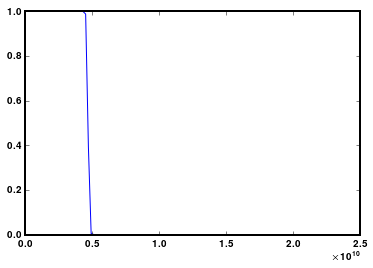

In [528]:
def get_f_k(k,Te,ne):
    
    #print('>>> get_FD_dist ... ')
    
    # Te : J
    # ne : 1/m^3
    
    E_K = (hbar*k)**2/(2*massElectronReduced) # J
    
    mu = get_mu(ne,Te) # J
    
    #print(E_K)
    
    exponent=(E_K-mu)/Te
        
    if exponent < 150 : 
        f_k = 1/(math.exp(exponent)+1) # unitless
    else : 
        f_k = 0
    
    if 0 : 
        print('exponent,f_k,Te/eV,ne,mu,E_K = ',
              "{:.3e}".format(exponent),
              "{:.3e}".format(f_k),
              "{:.3e}".format(Te/eV),
              "{:.3e}".format(ne),
              "{:.3e}".format(mu),
              "{:.3e}".format(E_K/eV))    
    
    return f_k # unitless

T = 0.03*eV
ne = 10**22*100**3
get_f_k(kmin_EAP,T,ne) 

#temp = [ T for T in np.arange(0.01,10,0.01)]
#f_k = [get_f_k(kmin_EAP,Te*eV,10**22*100**3)  for Te in temp]
#plt.plot(temp,f_k)

kvalue = [ k for k in np.arange(kmin_EAP,kBZ,(kBZ-kmin_EAP)/100)]
f_k = [get_f_k(k,T,ne)  for k in kvalue]
plt.plot(kvalue,f_k)

## get_OMEGA

omegaAO  (1/s) =  5548542.653501729
omegaLO1 (1/s) =  110564549791022.64
omegaLO2 (1/s) =  292517082890764.75


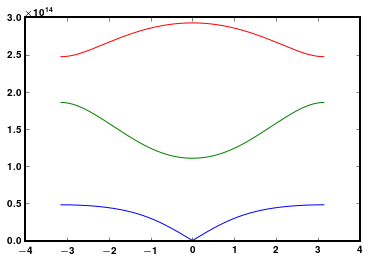

In [82]:
def get_OMEGA(ka,m):
    
    if 0 : print('>>> get_OMEGA ...')
    
    # Normal Vibrations and Their Dispersion in Syndiotactic Polystyrene
    # SHANTANU RASTOGI and V. D. GUPTA
    # J. MACKOMOL. SC1.-PHYS., B33(2), 129-141 (1994)
        
    alpha = -mPh*mCH*mCH2
    beta  = G*mCH2*(mCH+mPh)+2*K*mPh*(mCH+mCH2)
    gamma = (4*K**2*np.cos(ka/2)**2-2*K*(2*K+G))*mPh-2*G*K*(mCH+mCH2)
    delta = 4*G*K**2*(1-np.cos(ka/2)**2)
    
    p = -beta**2/(3*alpha**2)+gamma/alpha
    q = 2*beta**3/(27*alpha**3)-9*beta*gamma/(27*alpha**2)+delta/alpha
    
    argument = 1/3*np.arccos(3*q/(2*p)*np.sqrt(-3/p))+2*(m+1)*np.pi/3    
    zm = 2*np.sqrt(-p/3)*np.cos(argument)
    
    omega = np.sqrt(zm - beta/(3*alpha))
    
    #return omega*hbar/meV/2 # meV
    return omega # 1/s

omegaAO  = get_OMEGA(ka=0,m=0) # 1/s
omegaLO1 = get_OMEGA(ka=0,m=1) # 1/s
omegaLO2 = get_OMEGA(ka=0,m=2) # 1/s
    
print('omegaAO  (1/s) = ',omegaAO )
print('omegaLO1 (1/s) = ',omegaLO1)  
print('omegaLO2 (1/s) = ',omegaLO2)  

xdata    = [ ka for ka in np.arange(-np.pi,np.pi,0.01)]
ydata_m0 = [ get_OMEGA(ka=x,m=0) for x in xdata]
ydata_m1 = [ get_OMEGA(ka=x,m=1) for x in xdata]
ydata_m2 = [ get_OMEGA(ka=x,m=2) for x in xdata]

plt.plot(xdata,ydata_m0)
plt.plot(xdata,ydata_m1)
plt.plot(xdata,ydata_m2)

## get_report_omega

Save as                        : polystyrene_dispersion_relation
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


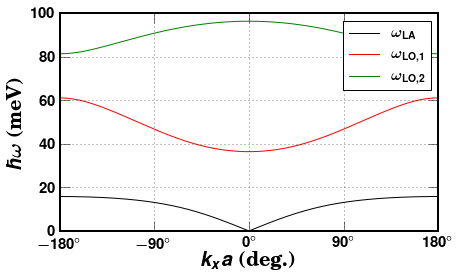

In [75]:
def get_report_omega(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.5,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{$\omega_{\mathrm{LA}}$}'
    label2 = r'\textbf{$\omega_{\mathrm{LO,1}}$}'
    label3 = r'\textbf{$\omega_{\mathrm{LO,2}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 

    ax1.plot(xdata,ydata_m0,c='k',label=label1)
    ax1.plot(xdata,ydata_m1,c='r',label=label2)
    ax1.plot(xdata,ydata_m2,c='g',label=label3)

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{$k_x a$ (deg.)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$\hbar \omega$ (meV)}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper right',numpoints=1)
    ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    plt.sca(ax1)
    plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
               [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'polystyrene_dispersion_relation'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report_omega(exportFlag=1)

## get_EAP_rate

In [314]:
def get_EAP_rate(k,Ti,rho):
    
    #print('>>> get_EAP_rate ...')

    # Ti : J
    # rho : kg/m^3
    
    factor_1 = Upotential**2*Ti*massElectronReduced
    factor_2 = 2*np.pi*rho*cs**2*hbar**3*k
    factor_3 = k**2 + (massElectronReduced*cs/hbar)**2
    
    return factor_1/factor_2*factor_3
    
get_EAP_rate(kmin_EAP,Ti,rho)

284991351957.0703

## get_EAP_rate_avg

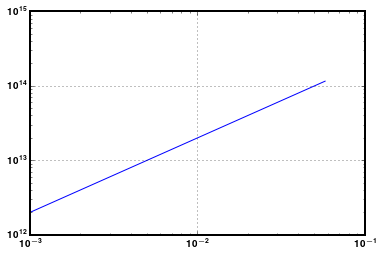

In [902]:
def get_EAP_rate_avg(Te,Ti,ne,rho):
    
    #print('>>> get_EAP_rate_avg ...')
    
    # Te : J
    # Ti : J
    # rho : kg/m^3
    # ne : 1/m^3
    
    #k = np.sqrt((3/2*Te)*2*massElectronReduced)/hbar
    
    V = (dCC*2)**3 # m^3
    
    g_k = 2*V/(8*np.pi**3) # m^3
    
    f_k = get_f_k(kmin_EAP,Te,ne)
    
    m = 2
    
    result1 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EAP_rate(k,Ti,rho) , kmin_EAP, kBZ)[0]

    result2 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m , kmin_EAP, kBZ)[0]
    
    residue = 10**-100
    
    EAP_rate_avg = result1/(result2+residue) # 1/s
    #EAP_rate_avg = result2 # 1/s
    
    if 0 :
        print('EAP_rate_avg = ',"{:.3e}".format(EAP_rate_avg),
              ', Te (eV) = ',"{:.3e}".format(Te/eV))    
    
    return EAP_rate_avg

    
T = 0.01*eV
ne = 10**22*100**3
get_EAP_rate_avg(T,T,ne,rho)
#get_EAP_rate_avg(Te,Ti,10**22*100**3,rho)

#temp = [ T for T in np.arange(0.01,100,0.01)]

temp      = [ T for T in np.arange(0.001,Tc/eV,0.0001)]
collFreq2 = [get_EAP_rate_avg(T*eV,T*eV,10**22*100**3,rho) for T in temp]

plt.loglog(temp,collFreq2)
plt.grid()

## get_EOP_rate

In [521]:
def get_EOP_rate(k,omega_LO,Ti,flag_emit,flag_absrob):
    
    #print('>>> get_EOP_rate ...')
    
    # omega_LO : 1/s
    # Ti : J

    factor1 = eCharge**2*massElectronReduced*omega_LO/(hbar**2*k)/(4*np.pi)
    factor2 = (1/varepsilon_infty - 1/varepsilon_0)/vacuumPermittivity    
    g_LO    = 1/(math.exp(hbar*omega_LO/Ti)-1)
    
    energy_LO  = hbar*omega_LO # J
    energy_ele = (hbar*k)**2/(2*massElectronReduced) # J
        
    if (flag_emit==1) and (flag_absrob==0) :
        inside = max(1 - energy_LO/energy_ele,0)
        ln     = np.log((1 + inside**0.5)/(1 - inside**0.5))
        rate   = factor1*factor2*(g_LO+1)*ln
        
        
    if (flag_emit==0) and (flag_absrob==1) :
        inside = 1 + energy_LO/energy_ele
        ln     = np.log((inside**0.5 + 1)/(inside**0.5 - 1))
        rate   = factor1*factor2*g_LO*ln
        
    if 0 :
        #print('factor1 = ',factor1)
        #print('factor2 = ',factor2)
        print('factor1*factor2 = ',"{:.3e}".format(factor1*factor2))
        print('g_LO = ',g_LO)
        #print('hbar*omega_LO/eV = ',hbar*omega_LO/eV)
        #print('energy_LO/eV = ',"{:.3e}".format(energy_LO/eV))
        #print('energy_ele/eV = ',"{:.3e}".format(energy_ele/eV))    
        #print('Ti/eV = ',Ti/eV)
        print('inside = ',"{:.3e}".format(inside))
        print('energy_LO/energy_ele = ',"{:.3e}".format(energy_LO/energy_ele))  
        print('ln = ',"{:.3e}".format(ln)) 
        print('rate = ',"{:.3e}".format(rate))     
        print()
            
    return rate # 1/s

T = 0.02*eV

EOP_emit1 = get_EOP_rate(kmin_EOP_emit1,omega_LO1,Ti,1,0)
EOP_emit2 = get_EOP_rate(kmin_EOP_emit2,omega_LO2,Ti,1,0)

#EOP_absrob1 = get_EOP_rate(kmin_EOP_absrob,omega_LO1,Ti,0,1)
#EOP_absrob2 = get_EOP_rate(kmin_EOP_absrob,omega_LO2,Ti,0,1)

#print(get_EOP_rate_avg(T*eV,T*eV,1*10**22*100**3,rho))

## get_EOP_rate_avg

In [854]:
def get_EOP_rate_avg(Te,Ti,ne,rho):
    
    #print('>>> get_EAP_rate_avg ...')
    
    # Te : J
    # Ti : J
    # rho : kg/m^3
    # ne : 1/m^3
    
    V = (dCC*2)**3 # m^3
    
    g_k = 2*V/(8*np.pi**3) # m^3
    
    m = 2
    
    result1 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO1,Ti,1,0) ,    kmin_EOP_emit1, kBZ)
    result2 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_emit1, kBZ)
    
    result3 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO2,Ti,1,0) ,    kmin_EOP_emit2, kBZ)
    result4 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_emit2, kBZ)
    
    result5 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO1,Ti,0,1) ,    kmin_EOP_absrob, kBZ)
    result6 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_absrob, kBZ)
    
    result7 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO2,Ti,0,1) ,    kmin_EOP_absrob, kBZ)
    result8 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_absrob, kBZ)
    
    residue = 10**-100
    
    EOP_rate_emit1 = result1[0]/(result2[0]+residue)
    EOP_rate_emit2 = result3[0]/(result4[0]+residue)
    EOP_rate_absorb1 = result5[0]/(result6[0]+residue)
    EOP_rate_absorb2 = result7[0]/(result8[0]+residue)   
    
    EOP_rate = EOP_rate_emit1*1   + \
               EOP_rate_emit2*1   + \
               EOP_rate_absorb1*1 + \
               EOP_rate_absorb2*1
    
    if 0 : 
        print('EOP_rate_emit1   = ',"{:.3e}".format(EOP_rate_emit1))
        print('EOP_rate_emit2   = ',"{:.3e}".format(EOP_rate_emit2))
        print('EOP_rate_absorb1 = ',"{:.3e}".format(EOP_rate_absorb1))    
        print('EOP_rate_absorb2 = ',"{:.3e}".format(EOP_rate_absorb2))
        
        print('result2[0] = ',"{:.3e}".format(result2[0]))        
        print('result4[0] = ',"{:.3e}".format(result4[0])) 
        print('result6[0] = ',"{:.3e}".format(result6[0]))                
    
    return EOP_rate
    
T = 0.058    
EAP_1 = get_EAP_rate_avg(T*eV,T*eV,1*10**22*100**3,rho)
EOP_1 = get_EOP_rate_avg(T*eV,T*eV,1*10**22*100**3,rho)

print(EAP_1,EOP_1,EOP_1/EAP_1)

if 0 : 
    temp0     = np.array([ T for T in np.arange(0.001,Tc/eV,0.0001)])
    collFreq2 = np.array([ get_EAP_rate_avg(T*eV,T*eV,3*10**22*100**3,rho) for T in temp0 ])
    collFreq3 = np.array([ get_EOP_rate_avg(T*eV,T*eV,3*10**22*100**3,rho) for T in temp0 ])

    plt.loglog(temp0,collFreq2)
    plt.loglog(temp0,collFreq3)
    plt.grid()

115353635880403.2 2601626157159467.0 22.55348205804966


## get_lambda_DH

In [586]:
def get_lambda_DH(Te,Ti,ne,ni):
        
    # Te : J
    # Ti : J  
    # ne : 1/m^3
    # ni : 1/m^3
    
    E_Fermi = get_E_Fermi(ne) # J    
    T_Fermi = E_Fermi*2/3     # J
    
    Te_erg = Te*J_to_erg      # erg
    Ti_erg = Ti*J_to_erg      # erg
    Tf_erg = T_Fermi*J_to_erg # erg
    
    ne_gcc = ne/gcm3_to_kgm3  # g/cm^3
    ni_gcc = ni/gcm3_to_kgm3  # g/cm^3
        
    part1 = 4*np.pi*ne_gcc*eCharge_ESU**2/np.sqrt(Te_erg**2+Tf_erg**2)
    part2 = 4*np.pi*ni_gcc*eCharge_ESU**2*Z_CH**2/Ti_erg
    
    lambda_DH_cm = (part1 + part2)**(-1/2)     # cm
    lambda_DH    = (part1 + part2)**(-1/2)/100 # m    
    
    if 0 : 
        print(' >>> get_lambda_DH ... ')    
        print('E_Fermi/eV = ',"{:.3e}".format(E_Fermi/eV))
        print('T_Fermi/eV = ',"{:.3e}".format(T_Fermi/eV))    
        print('part1 = ',"{:.3e}".format(part1))
        print('part2 = ',"{:.3e}".format(part2))    
        print('lambda_DH (m) = ',"{:.3e}".format(lambda_DH)) 
    
    return lambda_DH # m
    
get_lambda_DH(Te,Ti,10**22*100**3,n_a_CH)    

3.0633571043286097e-14

## get_R_cloest

In [601]:
def get_R_cloest(Te,Ti,ne,ni):
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni) # m
    
    w = lambertw(2*Z_CH*eCharge**2/(lambda_DH*Te)) # unitless
    
    R_cloest = lambda_DH*np.real(w) # m
    
    if 0 :
        print('>>> get_R_cloest ... ')    
        print('lambda_DH (m) = ',lambda_DH)
        print('w, np.real(w) = ',w,np.real(w))
        print('R_cloest  (m) = ',R_cloest)
    
    return R_cloest # m
    
get_R_cloest(Te,Ti,10**22*100**3,n_a_CH)    

8.958160238357753e-17

## get_R_Broglie

In [615]:
def get_R_Broglie(Te):    
    
    R_Broglie = hbar*(2*np.pi)/np.sqrt(massElectron*Te) # m
    
    if 0 : 
        print(' >>> get_R_Broglie ... ')    
        print('R_Broglie = ',R_Broglie)
    
    return R_Broglie # m
    
get_R_Broglie(Te)    

1.0976946109186968e-08

## get_theta

In [651]:
def get_theta(b,bmax,Te,Ti,ne,ni):
    
    print(' >>> get_theta ... ')
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni)
    
    R_cloest = get_R_cloest(Te,Ti,ne,ni)
    
    theta = integrate.quad(lambda r:r**(-2)*(1-2/Te*Z_CH*eCharge**2/r*math.exp(-r/lambda_DH)-(b/r)**2)**(-1/2),R_cloest,bmax) 
    
    print(theta)
    
#get_theta(0,1.9964727358293832e-10,Te,Ti,10**22*100**3,n_a_CH)   

## get_Coulomb_Log

In [654]:
def get_Coulomb_Log(Te,Ti,ne,ni):
         
    R_cloest = get_R_cloest(Te,Ti,ne,ni)
    
    R_Broglie = get_R_Broglie(Te)
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni)
    
    ai = (3/(4*np.pi*ni))**(1/3) # m
    
    bmin = 0.5 * max(R_cloest, R_Broglie) # m
        
    bmax = np.sqrt(lambda_DH**2+ai**2) # m
    
    Coulomb_Log = max(1/2*np.log(1+bmax**2/bmin**2),1)
        
    if 0 : 
        print('>>> get_Coulomb_Log ... ')        
        print('R_cloest  (m) = ',R_cloest)
        print('R_Broglie (m) = ',R_Broglie)
        print('bmin (m)      = ',bmin) 
        print('lambda_DH (m) = ',lambda_DH)
        print('ai (m)        = ',ai) 
        print('bmax (m)      = ',bmax)
        print('Coulomb_Log   = ',Coulomb_Log)
        
    return Coulomb_Log
    
get_Coulomb_Log(Te,Ti,10**22*100**3,n_a_CH)     

1

## get_vc_neutral

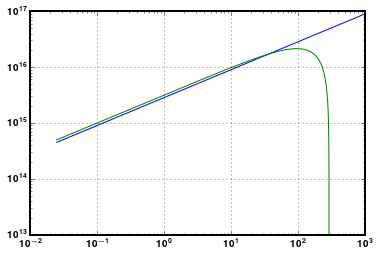

In [1579]:
def get_vc_neutral(Te,ni,ne,mode):
    
    sigma = np.pi*(dCC)**2 # m^2
    
    if mode == 0 : 
        n0 = ni - ne
        
    if mode == 1 :     
        Z_eff = get_Zeff(ni,Te)
        ne_eff = ni*Z_eff
        n0 = ni - min(ne_eff,ni)
    
    vc_neutral = n0*sigma*np.sqrt(Te/massElectron) # 1/s
    
    if 0 : 
        print('>>> get_vc_neutral ... ')
        print('vc_neutral = ',"{:.3e}".format(vc_neutral))
    
    return vc_neutral
    
#get_vc_neutral(1*eV,n_a_CH,0.025*eV,0.) 

temp4 = [ T for T in np.arange(0.025,1000,1)]
collFreq4_mode0 = [get_vc_neutral(T*eV,n_a_CH,1*10**22*100**3,0) for T in temp4]
collFreq4_mode1 = [get_vc_neutral(T*eV,n_a_CH,1*10**22*100**3,1) for T in temp4]

plt.loglog(temp4,collFreq4_mode0)
plt.loglog(temp4,collFreq4_mode1)
plt.grid()

## get_FD_integral

In [1127]:
def get_FD_integral(x):
        
    FD_integral = integrate.quad(lambda t:t**0.5/(1+math.exp(t-x)),0,100)[0]
    
    if 0 : 
        print(' >>> get_FD_integral ... ')
        print(' FD_integral ',FD_integral)
    
    return FD_integral
    
get_FD_integral(x)    

TypeError: unsupported operand type(s) for -: 'float' and 'list'

## get_Zeff

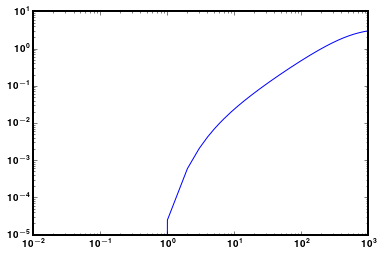

In [1477]:
def get_Zeff(ni,Te):
    
    # ni : 1/m^3
    # T : J
    
    # Phys. Plasmas 23, 042704 (2016); https://doi.org/10.1063/1.4945753
    # ni is the ion density
    
    T = Te/eV # eV
    
    a0 = 87.222
    a1 = 10.866
    a2 = -28.412
    a3 = 17.915
    a4 = -2.422
    a5 = 0.595
    a6 = -2.369*10**-2
    
    ai = (3/(4*np.pi*ni))**(1/3) # m
    
    Bohr_radius = 4*np.pi*vacuumPermittivity*hbar**2/(massElectron*eCharge**2) # m
    
    r0 = ai/Bohr_radius # no unit
    
    gamma0 = 1/(r0*T) # 1/eV
    
    fz = a1 + a2*T*((1+np.sqrt(3*gamma0))**(1/4)-1) + a3*T**0.9 + \
        (a4/r0 + a5/r0**2 + a6/r0**3)*T
    
    h = hbar*2*np.pi # J/K
    
    DB_wavelength = h/np.sqrt(massElectron*Te) # m
    
    RHS = a0/(ni*DB_wavelength**3)*math.exp(-fz/T)
    
    coeff = [1,RHS,-RHS]
    sol   = np.roots(coeff) 
    
    xi = max(sol)
    xi_Jack = (-RHS+np.sqrt(RHS**2+4*RHS))/2
    
    Zeff = xi*Zmax_CH
    
    if 0 : 
        print('>>> get_Zeff ...')
        print('Bohr_radius (m) = ',Bohr_radius)
        print('ai (m) = ',ai)
        print('a0 = ',a0)  
        print('gamma0 = ',gamma0)      
        print('fz = ',fz)
        print('xi = ',xi)
        print('xi_jack = ',xi_Jack)
        print('Zeff = ',Zeff)
        print('DB_wavelength (m) = ',DB_wavelength)  
        print('ni*DB_wavelength**3 = ',ni*DB_wavelength**3)
        print('a0/(ni*DB_wavelength**3) = ',a0/(ni*DB_wavelength**3))
        print('math.exp(-fz/T) = ',math.exp(-fz/T))
        print('sol = ',sol)
        
    return Zeff
    
get_Zeff(n_a_CH,1000*eV)  

xdata = [ne for ne in np.arange(0.01,1000,1)]
ydata = [get_Zeff(n_a_CH,T*eV)for T in xdata ]
plt.loglog(xdata,ydata)

## get_vc_ion

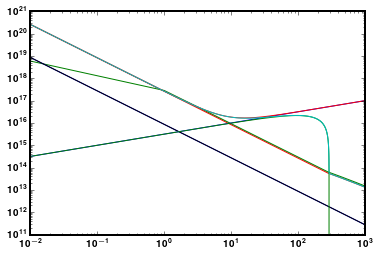

In [1580]:
def get_vc_ion(Te,Ti,ne,ni,degeneracy):
    
    Z_eff = ni/ne
    
    #Z_eff = get_Zeff(ni,Te)
    
    ne_gcc = ne/100**3 # g/cm^3
    
    me_cgs = massElectron*1000 # g
    
    Te_erg = Te*J_to_erg # erg
    
    Te_eV = Te/eV # eV
    
    Coulomb_Log = get_Coulomb_Log(Te,Ti,ne,ni) # unitless
    
    mu = get_mu(ne,Te) # J
    
    x = mu/Te # unitless
    
    FD_integral = get_FD_integral(x)+10**(-150)
    
    part1 = 2*np.sqrt(2)*np.pi/3
    
    part2 = Z_eff*eCharge_ESU**4*ne_gcc/np.sqrt(me_cgs)/Te_erg**1.5
    
    part3 = 1/(1+math.exp(-x))/FD_integral
    
    vc_ion = part1*part2*Coulomb_Log*part3**degeneracy
            
    Zlnlambda = 10
    # Ref[NRL : all quantities in CGS except Te in eV]
    vei_NRL = 2.91*10**-6*ne_gcc*Zlnlambda/(Te_eV**1.5) # 1/s with unit [Te] in eV    
    
    vei_WOO = math.sqrt(2)*ne*eCharge**4*Zlnlambda/ \
               (12*math.pi**1.5*vacuumPermittivity**2*math.sqrt(massElectron)*Te**1.5)    
    
    if degeneracy == 2 : vc_ion = vei_NRL
    if degeneracy == 3 : vc_ion = vei_WOO

    if 0 : 
        print('>>>> get_vc_ion ...')
        print('part1 = ',part1)    
        print('part2 = ',part2)
        print('part3 = ',part3)    
        print('Coulomb_Log = ',Coulomb_Log)   
        print('mu = ',mu)  
        print('FD_integral = ',FD_integral)   
        print('Te/eV = ',Te/eV)
        print('degeneracy = ',degeneracy)
        print('vei = ',vei)
        print('vc_ion = ',vc_ion)        
        
    return vc_ion
    
#get_vc_ion(Te,Ti,10**22*100**3,n_a_CH,0) 

NE_IN = 3*10**20*100**3

if 1 : 
    temp5 = [ T for T in np.arange(0.01,1000,1)]
    collFreq5   = np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,0) for T in temp5])
    collFreq5QM = np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,1) for T in temp5])
    collFreq5NRL= np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,2) for T in temp5])
    collFreq5WOO= np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,3) for T in temp5])
    
    # get_vc_neutral(Te,ni,ne)
    collFreq4_mode0 = np.array([get_vc_neutral(T*eV,n_a_CH,NE_IN,0) for T in temp5])
    collFreq4_mode1 = np.array([get_vc_neutral(T*eV,n_a_CH,NE_IN,1) for T in temp5])    

    plt.loglog(temp5,collFreq5,   c='r')
    plt.loglog(temp5,collFreq5QM, c='g')
    plt.loglog(temp5,collFreq5NRL,c='b')
    plt.loglog(temp5,collFreq5WOO,c='k')
    
    plt.loglog(temp5,collFreq4_mode0)
    plt.loglog(temp5,collFreq4_mode1)    
    plt.loglog(temp5,collFreq4_mode0[:]+collFreq5[:]) 
    plt.loglog(temp5,collFreq4_mode1[:]+collFreq5[:])     

## get_vc_new

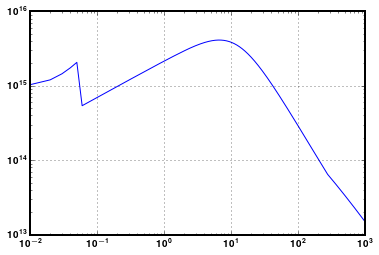

In [1582]:
def get_vc_new(Te,Ti,ne,ni,rho):
    
    if 0 : 
        print('Te/eV = ',"{:.3e}".format(Te/eV))
        print('Ti/eV = ',"{:.3e}".format(Ti/eV))
        print('ne    = ',"{:.3e}".format(ne))
        print('ni    = ',"{:.3e}".format(ni))        
        print('rho   = ',"{:.3e}".format(rho))           
        
    vc_neutral = get_vc_neutral(Te,ni,ne,0)
    
    degeneracy = 1
    
    vc_ion = get_vc_ion(Te,Ti,ne,ni,degeneracy)
    
    XPS = (np.tanh(-(Te-Tc))+1)/2
    
    XAM = (np.tanh(+(Te-Tc))+1)/2
    
    ve = math.sqrt(1.5*Te/massElectron) # m/s
    vmpf = ve*ni**(1/3) # 1/s    
    
    if Ti<Tc : 
        EAP_rate_avg = get_EAP_rate_avg(Te,Ti,ne,rho)
        EOP_rate_avg = get_EOP_rate_avg(Te,Ti,ne,rho)        
        vc_new = (EAP_rate_avg + EOP_rate_avg)*1
        
    #if (Te>=Tc) and (Te<eV) : vc_new = vc_neutral
    if (Ti>=Tc) : 
        #vc_new = vc_neutral+vc_ion
        vc_new = 1/(1/vc_neutral+1/vc_ion)
        #vc_new = 1/(1/vmpf+1/vc_ion)
    
    if 0 : 
        print('>>> get_vc_new ... ')     
        print('EAP_rate_avg (1/s) = ',"{:.3e}".format(EAP_rate_avg))
        print('EOP_rate_avg (1/s) = ',"{:.3e}".format(EOP_rate_avg)) 
        print('vc_neutral (1/s)   = ',"{:.3e}".format(vc_neutral))
        print('vc_ion (1/s)       = ',"{:.3e}".format(vc_ion))
        print('vc_new (1/s)       = ',"{:.3e}".format(vc_new))
    
    return vc_new
        
#get_vc_new(Te,Ti,3*10**22*100**3,n_a_CH,rho) 

temp6 = [ T for T in np.arange(0.01,1000,0.01)]
collFreq6  = [get_vc_new(T*eV,T*eV,3*10**22*100**3,n_a_CH,rho) for T in temp6]
plt.loglog(temp6,collFreq6)
plt.grid()

## get_vc

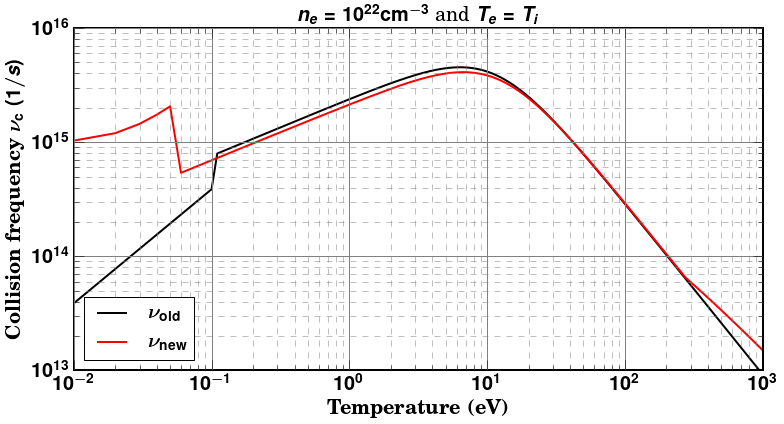

In [1583]:
def get_vc(Te,Til,nfe,na,mode):
    
    # Te unit  : eV
    # Til unit : eV
    # nfe unit : 1/m^3
    # na unit  : 1/m^3
    
    if Til <= 0.1 : 
        vph0 = 10**14 # 1/s
        T0 = 300*kelvin_to_eV # eV
        vc = vph0*Til/T0 # 1/s
    
    if Til > 0.1 :
        Zlnlambda = 10
        # Ref[NRL : all quantities in CGS except Te in eV]
        vei_NRL = 2.91*10**-6*(nfe/100**3)*Zlnlambda/(Te**1.5) # 1/s with unit [Te] in eV
        # Ref[Spitzer]
        vei_WOO = math.sqrt(2)*nfe*eCharge**4*Zlnlambda/ \
              (12*math.pi**1.5*vacuumPermittivity**2*math.sqrt(massElectron)*(Te*eV)**1.5) # 1/s
        # Ref[Lee-More : An electron conductivity model for dense plasmas]
        ve = math.sqrt(1.5*Te*eV/massElectron) # m/s
        vmpf = ve*na**(1/3) # 1/s
        if mode==0 : vc = 1/(1/vmpf+1/vei_NRL) # 1/s
        if mode==1 : vc = 1/(1/vmpf+1/vei_WOO) # 1/s
        
    if Til > 1000:
        # Ref[Spitzer]
        vei = math.sqrt(2)*nfe*eCharge**4*Zlnlambda/ \
              (12*math.pi**1.5*vacuumPermittivity**2*math.sqrt(massElectron)*(Te*eV)**1.5)
        vc = vei

    return vc # 1/s

plot=1
if plot==1:
    
    ne_IN = 1*10**22*100**3
    temp = [ T for T in np.arange(0.01,1000,0.01) ]
    collFreq_NRL = [get_vc(T,T,ne_IN,n_a_CH,0) for T in temp]
    collFreq_WOO = [get_vc(T,T,ne_IN,n_a_CH,1) for T in temp]
         
    plt.figure(figsize=[11,6])
    
    #plt.loglog(temp,collFreq_NRL,lw=2,ls='dashed',   basex=10, c='red', label=r'$\nu_{\mathrm{old,NRL}}$')
    plt.loglog(temp,collFreq_WOO,lw=2,basex=10,c='k',label=r'$\nu_{\mathrm{old}}$')
    #plt.loglog(temp0,collFreq2,lw=2, basex=10, c='b', label=r'$\nu_{LA}$')
    #plt.loglog(temp0,collFreq3,lw=2, basex=10, c='r', label=r'$\nu_{LO}$')
    #plt.loglog(temp0,collFreq2[:]+collFreq3[:],lw=1, basex=10, color='r',           label=r'$\nu_{LA}+\nu_{LO}$')
    
    #plt.loglog(temp4,collFreq4,lw=2, basex=10, color='purple', label=r'$\nu_{en}$') 
    #plt.loglog(temp5,collFreq5WOO,lw=2, basex=10, color='green', label=r'$\nu_{ei}$')     
    plt.loglog(temp6,collFreq6,lw=2,basex=10,color='r',label=r'$\nu_{\mathrm{new}}$') 
  
    title = r'$n_{e} = 10^{22}\mathrm{cm^{-3}}$ and $T_{e} = T_{i}$'
    
    plt.legend(fontsize=20,loc='lower left')
    plt.title(title,fontsize=20)
    plt.xlabel(r'\textbf{Temperature (eV)}',fontsize=20)
    plt.ylabel(r'\textbf{Collision frequency $\nu_{\mathrm{c}}~(1/s)$}',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tick_params(direction='in',right=True,top=True,length=10)
    plt.tick_params(which='minor',length=5,right=True,direction='in',top=True)
    plt.ylim([10**13,10**16])
    plt.xlim([0.01,1000])
    plt.grid(which='major', linestyle='-', linewidth='1', color='grey')
    plt.grid(which='minor', linestyle='--', linewidth='0.5', color='grey')
    
    plt.tight_layout()
    if 0 : 
        export_name = 'collisional_freq_new_V5'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 

# Heat Capacity

## get_cp_solid

In [1517]:
def get_cp_solid(T):
    
    # T : K
    
    a1 = -0.098338
    a2 = -1.30958
    a3 = 6.5499
    a4 = -8.13656
 
    cp_solid_1 = math.exp(a1*np.log(T)**3 + a2*np.log(T)**2 + a3*np.log(T) + a4)    
    cp_solid_2 = 7.7551*10**5*T**(-2) + 0.53447*T - 41.58
    cp_molten  = 0.2653*T + 95.12
    
    if (T>=10) and (T<200)  : cp = cp_solid_1
        
    if (T>=200) and (T<373) : cp = cp_solid_2
        
    if (T>=373) and (T<1000) : cp = cp_molten      
    
    return cp

## get_cp_data_lowT

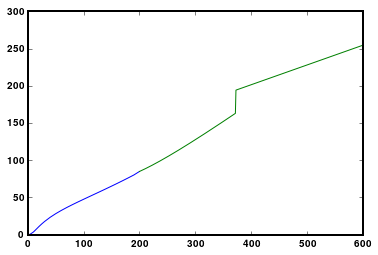

In [1540]:
def get_cp_data_lowT():
    
    data =np.array([[0,0],
          [0.1,0.0000633],
          [0.2,0.000132],
          [0.3,0.000269],
          [0.4,0.000496],
          [0.5,0.000838],
          [0.6,0.00133],
          [0.7,0.00200],
          [0.8,0.00288],
          [0.9,0.00401],
          [1.0,0.00543],
          [1.2,0.00929],
          [1.4,0.01480],
          [1.6,0.02231],
          [1.8,0.03217],
          [2.0,0.04477],
          [3.0,0.1622],
          [4.0,0.4058],
          [5.0,0.8215],
          [10,3.33],
          [15,7.03],
          [20,10.77],
          [25,14.26],
          [30,17.47],
          [40,23.13],
          [50,28.01],
          [60,32.37],
          [70,36.38],
          [80,40.17],
          [90,43.81],
          [100,47.37],
          [120,54.38],
          [130,57.89],
          [140,61.43],
          [150,65.01],
          [160,68.65],
          [170,72.36],
          [180,76.14],
          [190,80.01],
          [200,84.70175]])
    
    return data # J/mol/K

cp_data_lowT = get_cp_data_lowT()
plt.plot(cp_data_lowT[:,0],cp_data_lowT[:,1])

temp = [ T for T in range(200,600,1)]
cp_solid = [ get_cp_solid(T) for T in temp ]
plt.plot(temp,cp_solid)

## func_T3_law

In [1520]:
def func_T3_law(T,TD):
    # T : K
    # TD : K
    gas_constant = mole*kB # J/mole/K    
    return 12*np.pi**4/5*gas_constant*(T/TD)**3

## get_T_Debye

T_Debye (K) =  66.87350842025788
T_Debye (meV) =  5.765658687402574


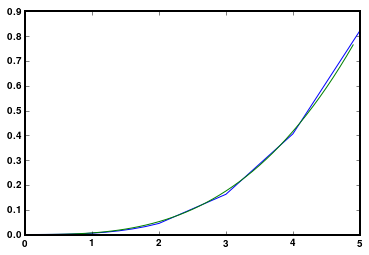

In [1548]:
def get_T_Debye(cp_data_lowT):
    
    data = []
    for ele in cp_data_lowT:
        if ele[0]<10 : data.append(ele)
    data = np.array(data)
        
    gas_constant = mole*kB # J/mole/K
        
    xdata = data[:,0]
    ydata = data[:,1]
     
    popt, pcov = curve_fit(func_T3_law, xdata, ydata)
    T_Debye = popt[0]
    
    xdata_fit = [T for T in np.arange(0,5,0.1)]
    ydata_fit = func_T3_law(xdata_fit,T_Debye) 
    
    plt.plot(xdata,ydata)
    plt.plot(xdata_fit,ydata_fit) 
    
    print('T_Debye (K) = ',popt[0])
    print('T_Debye (meV) = ',popt[0]*kelvin_to_eV*1000)    
    
    return T_Debye

T_Debye = get_T_Debye(cp_data_lowT)

## get_Vexpansion

In [1525]:
def get_Vexpansion(T):
    
    # molar volume of a repeat unit
    Vm = 92.8*10**-6 # m^3/mol 
    
    # volumetric coefficient
    ag = 2.37*10**-4
    ar = 5.74*10**-4 

    bulk_modulus = 3.58*10**9 # Pa
    
    Vexpansion = Vm*ag**2*bulk_modulus*T
    
    return Vexpansion

## get_Einstein_function

0


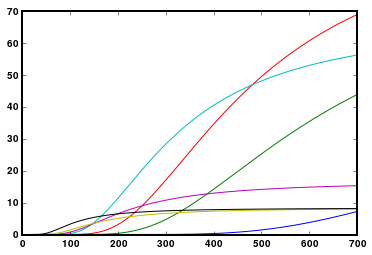

In [1526]:
def get_Einstein_function(T,theta,N):
    
    R = 8.3145 # J/mole/K  
       
    if theta/T > 200 : 
        Einstein_function = 0
    else : 
        part1 = (theta/T)**2*math.exp(theta/T)
        part2 = (math.exp(theta/T) - 1)**2        
        Einstein_function = N*R*part1/part2
    
    return Einstein_function

print(get_Einstein_function(1,350,1))

if 1 :     
    temp = [ T for T in range(1,700,1)]
    plt.plot(temp,[get_Einstein_function(T,4000,8) for T in temp])      
    plt.plot(temp,[get_Einstein_function(T,2000,10) for T in temp])      
    plt.plot(temp,[get_Einstein_function(T,1500,12) for T in temp])      
    plt.plot(temp,[get_Einstein_function(T,1000,8) for T in temp])    
    plt.plot(temp,[get_Einstein_function(T,700,2) for T in temp])
    plt.plot(temp,[get_Einstein_function(T,500,1) for T in temp])
    plt.plot(temp,[get_Einstein_function(T,350,1) for T in temp])

## get_cp_group

74.9506385416552


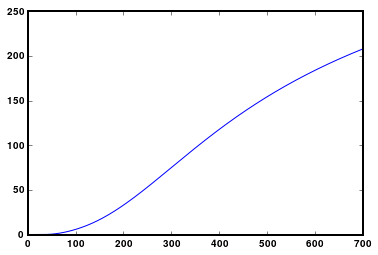

In [1527]:
def get_cp_group(T):
    
    cp_group = get_Einstein_function(T,4000,8) +\
               get_Einstein_function(T,2000,10) +\
               get_Einstein_function(T,1500,12) +\
               get_Einstein_function(T,1000,8) +\
               get_Einstein_function(T,700,2) +\
               get_Einstein_function(T,500,1) +\
               get_Einstein_function(T,350,1)
    
    dimension = 1
    return cp_group*dimension # J/mol/K

print(get_cp_group(300))

if 1 :
    temp = [ T for T in range(1,700,1)]
    cp_group = [ get_cp_group(T) for T in temp ]
    plt.plot(temp,cp_group)

## get_cp_skeletal

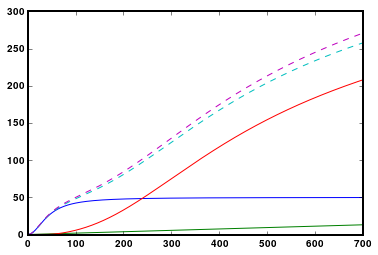

In [1544]:
def get_cp_skeletal(T):
    
    R = 8.3145 # J/mole/K
    
    #CT = 6 R [ (T/42.5)^2 / (1 + (T/42.5)^2)]    
    #CP - CV = -T (dV/dT)2P / (dV/dP)2T = Vα2BT
    
    cp_skeletal = 6 * R * ((T/42.5)**2 / (1 + (T/42.5)**2))
    
    return cp_skeletal

if 1 :
    temp = np.array([ T for T in range(1,700,1)])
    cp_skeletal = np.array([ get_cp_skeletal(T) for T in temp ])    
    plt.plot(temp,cp_skeletal)
    
    Vexpansion = np.array([ get_Vexpansion(T) for T in temp ])
    plt.plot(temp,Vexpansion) 
    
    cp_group = np.array([ get_cp_group(T) for T in temp ])
    plt.plot(temp,cp_group)
    
    temp2 = [ T for T in range(200,700,1)]
    cp_solid = np.array([ get_cp_solid(T) for T in temp2 ])

    cp_Debye = [ func_T3_law(T,T_Debye) for T in temp]    
    
    plt.plot(temp,cp_skeletal+cp_group,ls='dashed') 
    plt.plot(temp,cp_skeletal+cp_group+Vexpansion,ls='dashed')     

## get_report_cp

Save as                        : polystyrene_heat_capacity
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


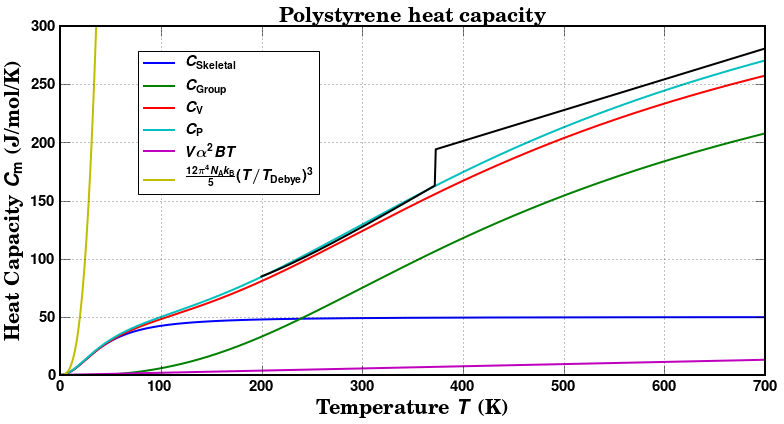

In [1546]:
def get_report_cp(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[11,6])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{$C_{\mathrm{Skeletal}}$}'
    label2 = r'\textbf{$C_{\mathrm{Group}}$}'
    label3 = r'\textbf{$C_{\mathrm{V}}$}'
    label4 = r'\textbf{$C_{\mathrm{P}}$}'
    label5 = r'\textbf{$V\alpha^2BT$}'
    label6 = r'\textbf{Exp. data}' 
    label7 = r'\textbf{$\frac{12\pi^4N_{\mathrm{A}}k_{\mathrm{B}}}{5}(T/T_{\mathrm{Debye}})^3$}'    

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    yfactor = 1#1/mole/kelvin_to_eV/eV

    ax1.plot(temp,cp_skeletal*yfactor,lw=2,label=label1)    
    ax1.plot(temp,cp_group*yfactor,lw=2,label=label2)    
    ax1.plot(temp,(cp_skeletal+cp_group)*yfactor,lw=2,label=label3)
    ax1.plot(temp,(cp_skeletal+cp_group+Vexpansion)*yfactor,lw=2,label=label4)
    ax1.plot(temp,Vexpansion*yfactor,lw=2,label=label5) 
    
    #ax1.plot(cp_data_lowT[:,0],cp_data_lowT[:,1],lw=2,c='k')        
    ax1.plot(temp2,cp_solid,lw=2,c='k')    
    ax1.plot(temp,cp_Debye,lw=2,label=label7)     
     
    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Temperature $T$ (K)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{Heat Capacity $C_{\mathrm{m}}$ (J/mol/K)}',fontsize=fs) 
    #ax1.set_ylabel(r'\textbf{Heat Capacity $C_\mathrm{m}^\mathrm{J/mol/K}\times 0.12$}',fontsize=fs)
    ax1.set_title(r'\textbf{Polystyrene heat capacity}',fontsize=fs)      
    ax1.legend(fontsize=fs2,loc='upper left',bbox_to_anchor=[0.1,0.95],numpoints=1)
    ax1.set_ylim([0,300])
    ax1.grid()


    plt.tight_layout()
    if exportFlag : 
        export_name = 'polystyrene_heat_capacity'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report_cp(exportFlag=1)

# Light Wave Propagation

## get_param

In [930]:
um = 10**-6 # m
nm = 10**-9 # m
ns = 10**-9 # s
ps = 10**-12 # s
fs = 10**-15 # s
eV = 1.6*10**-19 # J
kelvin_to_eV = 8.621738*10**-5 # eV 

lightSpeed = 299792458 # m/s
vacuumPermittivity = 8.854*10**-12 # C⋅V−1⋅m−1
epsilon0 = 8.854187817e-12 # vacuum permitivity [F/m] 1.e7_dp / (4*pi*c*c) 

# angular frequencies of laser
wavelength_355nm = 355*nm # m
wavelength_450nm = 450*nm # m
omega_355nm = 2*np.pi*(lightSpeed/wavelength_355nm) # 1/s
omega_450nm = 2*np.pi*(lightSpeed/wavelength_450nm) # 1/s

PlanckConstant = 6.62607015*10**-34 # J.s
hbar = PlanckConstant/(2*math.pi) # J.s

# input  laser intensity unit : W/m^2
# output electric field  unit : V/m
vacuumRefractiveIndex = 1
coef_laserI_eField = (2/lightSpeed/vacuumPermittivity/vacuumRefractiveIndex)**0.5

eCharge = 1.602176634*10**-19 # C
massElectron = 9.10938356*10**-31 # kg
massElectronReduced = massElectron/2 # kg

eCharge_CGS = 4.80326*10**-10 # esu
massElectron_CGS = 9.10938356*10**-31*1000 # g

beam_radius = 430*um # m
beam_area   = np.pi*beam_radius**2 # m^2

probe_fluence   = 0.1*0.001*100**2 # J/m^2
probe_duration  = 20*fs # s
probe_intensity = probe_fluence/probe_duration # W/m^2

sigma2 = 7*10**8 # cm.s/J^2

# mass_density/total_ion_mass*Z_total [1/cm^3]
R_CH = 1.03*1000 # kg/m^3
Z_CH = 7 # no unit
A_CH = (12.011+1.008)*1.66053904e-27 # kg
n_vb_CH = Z_CH*R_CH/A_CH # [1/m^3]
Eg_CH   = 4.05*eV # [J]
n_a_CH  = 3*10**22*100**3 # 1/m^3
rho = 1*gcm3_to_kgm3 # kg/m^3

print('probe_intensity [W/m^2]  = ',"{:.2e}".format(probe_intensity))
print('probe_intensity/100**2   = ',"{:.2e}".format(probe_intensity/100**2),'[W/cm^2]')
print('Eg_CH   [J]              = ',Eg_CH)
print('rho_CH  [kg/m^3]         = ',R_CH)
print('n_vb_CH [1/m^3]          = ',"{:.3e}".format(n_vb_CH))
print('n_a_CH  [1/m^3]          = ',"{:.3e}".format(n_a_CH))

probe_intensity [W/m^2]  =  5.00e+13
probe_intensity/100**2   =  5.00e+09 [W/cm^2]
Eg_CH   [J]              =  6.48e-19
rho_CH  [kg/m^3]         =  1030.0
n_vb_CH [1/m^3]          =  3.335e+29
n_a_CH  [1/m^3]          =  3.000e+28


## get_data_pulse

In [1567]:
def get_data_pulse(file_name):
    file_to_open = open(file_name,'r')
    pulse = []
    for line in file_to_open:
        row = line.split()
        tmp = []
        for ele in row:
            tmp.append(float(ele))
        pulse.append(tmp)
    pulse = np.array(pulse)
    pulse[:,1] = pulse[:,1]/beam_area*10**12 # change TW into W/m^2
    return pulse

file_name = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/RIGEL_DATA/pulse_1.dat'
pulse_1 = get_data_pulse(file_name)

file_name = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/RIGEL_DATA/pulse_2.dat'
pulse_2 = get_data_pulse(file_name)

file_name = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/RIGEL_DATA/pulse_3.dat'
pulse_3 = get_data_pulse(file_name)

file_name = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/RIGEL_DATA/pulse_4.dat'
pulse_4 = get_data_pulse(file_name)

pulse_1_Imax = max(pulse_1[:,1])
pulse_2_Imax = max(pulse_2[:,1])
pulse_3_Imax = max(pulse_3[:,1])
pulse_4_Imax = max(pulse_4[:,1])

npos = list(pulse_1[:,1]).index(pulse_1_Imax)
pulse_1_Imax_TimePs = pulse_1[npos][0]*1000
print('pulse_1_Imax_TimePs = ',pulse_1_Imax_TimePs)

npos = list(pulse_2[:,1]).index(pulse_2_Imax)
pulse_2_Imax_TimePs = pulse_2[npos][0]*1000
print('pulse_2_Imax_TimePs = ',pulse_2_Imax_TimePs)

npos = list(pulse_3[:,1]).index(pulse_3_Imax)
pulse_3_Imax_TimePs = pulse_3[npos][0]*1000
print('pulse_3_Imax_TimePs = ',pulse_3_Imax_TimePs)

npos = list(pulse_4[:,1]).index(pulse_4_Imax)
pulse_4_Imax_TimePs = pulse_4[npos][0]*1000
print('pulse_4_Imax_TimePs = ',pulse_4_Imax_TimePs)

print('pulse_1_Imax (W/cm^2) = ',"{:.3e}".format(pulse_1_Imax*100**-2))
print('pulse_2_Imax (W/cm^2) = ',"{:.3e}".format(pulse_2_Imax*100**-2))
print('pulse_3_Imax (W/cm^2) = ',"{:.3e}".format(pulse_3_Imax*100**-2))
print('pulse_4_Imax (W/cm^2) = ',"{:.3e}".format(pulse_4_Imax*100**-2))

pulse_1_Imax_TimePs =  115.0
pulse_2_Imax_TimePs =  115.0
pulse_3_Imax_TimePs =  175.0
pulse_4_Imax_TimePs =  145.0
pulse_1_Imax (W/cm^2) =  5.698e+10
pulse_2_Imax (W/cm^2) =  1.200e+11
pulse_3_Imax (W/cm^2) =  5.406e+11
pulse_4_Imax (W/cm^2) =  5.199e+13


## get_report_pulse

Imax_1 (TW/cm^2) =  0.05698246204804474
Imax_2 (TW/cm^2) =  0.11999025996219692
Imax_3 (TW/cm^2) =  0.5405587034164969


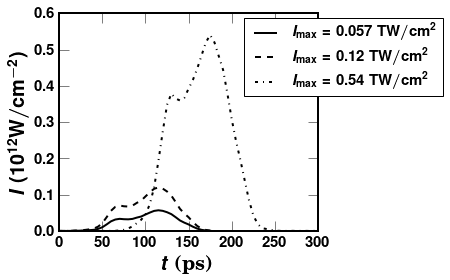

In [858]:
def get_report_pulse(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.5,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{$I_{\mathrm{max}}=0.057 ~\mathrm{TW/cm^2}$}'
    label2 = r'\textbf{$I_{\mathrm{max}}=0.12 ~\mathrm{TW/cm^2}$}'
    label3 = r'\textbf{$I_{\mathrm{max}}=0.54 ~\mathrm{TW/cm^2}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 

    unit_x = 1000
    unit_y = (100**-2)*(10**-12)
    ax1.plot(pulse_1[:,0]*unit_x,pulse_1[:,1]*unit_y,'-',c='k',lw=2,label=label1)
    ax1.plot(pulse_2[:,0]*unit_x,pulse_2[:,1]*unit_y,'--',c='k',lw=2,label=label2)
    ax1.plot(pulse_3[:,0]*unit_x,pulse_3[:,1]*unit_y,'-.',c='k',lw=2,label=label3)
    #ax1.plot(pulse_4[:,0]*unit_x,pulse_4[:,1]*unit_y)

    print('Imax_1 (TW/cm^2) = ',max(pulse_1[:,1]*unit_y))
    print('Imax_2 (TW/cm^2) = ',max(pulse_2[:,1]*unit_y))
    print('Imax_3 (TW/cm^2) = ',max(pulse_3[:,1]*unit_y))

    #ax1.set_xlim([10028,10034])
    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{$t$ (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$I ~(\mathrm{10^{12}W/cm^{-2}})$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='center',bbox_to_anchor=[1.1,0.8])

    plt.tight_layout()
    if exportFlag : 
        export_name = 'pulse_1_to_3_intensities'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report_pulse(exportFlag=0)              

## get_nc

In [859]:
def get_nc(wavelength):
    
    # input wavelength unit : m
    # output nc unit : 1/m^3
    
    angular_freq = 2*math.pi*(lightSpeed/wavelength)
    ne_crit = vacuumPermittivity*massElectron*angular_freq**2/eCharge**2
    return ne_crit # (1/m^3)

## get_WPI

In [1231]:
def Sumfunction(K1,K2,E1,E2,Nmax,x):
    summation = 0
    for n in range(0,Nmax+1):
        Z1 = math.pi**2*(2*math.modf(x+1)[1] - 2*x + n)
        Z2 = 2*K2*E2
        z = math.sqrt(Z1/Z2)
        summation += math.exp(-math.pi*n*(K1 - E1)/E2)*Phifunction(z)
    return summation
    
def Phifunction(z):
    integrand = lambda y: math.exp(y**2-z**2)
    phi = integrate.quad(integrand, 0, z)
    return phi[0]

def ellipK(x):
    integrand = lambda y: 1/math.sqrt(1-x**2*math.sin(y)**2)
    output = integrate.quad(integrand, 0, math.pi/2)
    return output[0]

def ellipE(x):
    integrand = lambda y: math.sqrt(1-x**2*math.sin(y)**2)
    output = integrate.quad(integrand, 0, math.pi/2)
    return output[0]

def check_idensity():
    x = 0.5
    
    identity_wrong = scipy.special.ellipk(x)*scipy.special.ellipe(math.sqrt(1-x**2)) + \
    scipy.special.ellipe(x)*scipy.special.ellipk(math.sqrt(1-x**2)) - \
    scipy.special.ellipk(x)*scipy.special.ellipk(math.sqrt(1-x**2))

    identity_correct = ellipK(x)*ellipE(math.sqrt(1-x**2)) + \
    ellipE(x)*ellipK(math.sqrt(1-x**2)) - ellipK(x)*ellipK(math.sqrt(1-x**2))

    print('x = ',x,', identity_correct = ',identity_correct,', identity_wrong = ',identity_wrong,)
    print('ellipE(x) = ',ellipE(x))
    print('ellipK(x) = ',ellipK(x))
    
check_idensity()    

def WPIfunction(laserI_IN,laserE,Nmax,omega_IN,bangGap):
    
    # laserI_IN unit : W/m^2
    # laserE unit : V/m
    # omega_IN unit : 1/s
    # bangGap  unit : J
    
    # laserI unit : W/cm^2
    laserI = laserI_IN/100**2
    
    # definitions of gamma1 and gamma2 are different from Arnab
    gamma = omega_IN*math.sqrt(massElectronReduced*bangGap)/(eCharge*laserE)  
    gamma1 = gamma/(1+gamma**2)**0.5
    gamma2 = gamma1/gamma
    
    elliptics = 0
    if elliptics==0:
        K1 = scipy.special.ellipk(gamma1)
        K2 = scipy.special.ellipk(gamma2)
        E1 = scipy.special.ellipe(gamma1)
        E2 = scipy.special.ellipe(gamma2)
    elif elliptics==1:
        K1 = ellipk(gamma1)
        K2 = ellipk(gamma2)
        E1 = ellipe(gamma1)
        E2 = ellipe(gamma2)
    
    # L. V. Keldysh Eq.(38)
    bangGapEffective = 2*bangGap*E2/(math.pi*gamma1)
    x = bangGapEffective/(hbar*omega_IN)
    
    Qvalue = math.sqrt(math.pi/2/K2)*Sumfunction(K1,K2,E1,E2,Nmax,x)
    
    # Jack's WPI is about three times smaller than Arnab's WPI
    WPI = 2*omega_IN/(9*math.pi)*(omega_IN*massElectronReduced/(hbar*gamma1))**1.5*\
    Qvalue*math.exp(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)*10**-6 # 1/(s.cm^3)
    
    # laserI unit : J/(s.cm^2)
    # sigma2 unit : cm.s/J^2
    WPI_appro = sigma2*laserI**2 # 1/(s.cm^3)
    
    return [WPI,WPI_appro]

def get_WPI(laserI,laserE,Nmax,omega_IN,bangGap):
    
    # laserI unit : W/cm^2
    # laserE unit : V/m
    # omega_IN unit : 1/s
    # bangGap  unit : J
    
    # definitions of gamma1 and gamma2 are different from Arnab
    gamma = omega_IN*math.sqrt(massElectronReduced*bangGap)/(eCharge*laserE)  
    gamma1 = gamma/(1+gamma**2)**0.5
    gamma2 = gamma1/gamma
    
    elliptics = 0
    if elliptics==0:
        K1 = scipy.special.ellipk(gamma1)
        K2 = scipy.special.ellipk(gamma2)
        E1 = scipy.special.ellipe(gamma1)
        E2 = scipy.special.ellipe(gamma2)
    elif elliptics==1:
        K1 = ellipk(gamma1)
        K2 = ellipk(gamma2)
        E1 = ellipe(gamma1)
        E2 = ellipe(gamma2)
    
    # L. V. Keldysh Eq.(38)
    bangGapEffective = 2*bangGap*E2/(math.pi*gamma1)
    x = bangGapEffective/(hbar*omega_IN)
    
    Qvalue = math.sqrt(math.pi/2/K2)*Sumfunction(K1,K2,E1,E2,Nmax,x)
    
    # Jack's WPI is about three times smaller than Arnab's WPI
    WPI = 2*omega_IN/(9*math.pi)*(omega_IN*massElectronReduced/(hbar*gamma1))**1.5*\
    Qvalue*math.exp(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)*10**-6 # 1/(s.cm^3)
    
    # laserI unit : J/(s.cm^2)
    # sigma2 unit : cm.s/J^2
    WPI_appro = sigma2*laserI**2 # 1/(s.cm^3)
    
    return WPI*100**3/2 # 1/(s.m^3)

laserI0 = 10000000000 # W/m^2
laserE1 = coef_laserI_eField*math.sqrt(laserI0) # V/m
laserE2 = math.sqrt(2*laserI0/(epsilon0*lightSpeed))  # V/m
W_PI , W_PI_appro = WPIfunction(laserI_IN=laserI0,laserE=laserE2,Nmax=50,
                                omega_IN=omega_355nm,bangGap=Eg_CH)
print()
print('laserI  [W/m^2] = ',laserI0)
print('laserE1 [V/m]   = ',laserE1)
print('laserE2 [V/m]   = ',laserE2)
print('laserE1/laserE2 = ',laserE1/laserE2,np.sqrt(2))
print('W_PI,W_PI_appro = ',W_PI , W_PI_appro,'[1/s/cm^3]')
print('W_PI/W_PI_appro = ',W_PI/W_PI_appro)

x =  0.5 , identity_correct =  1.5707963267948961 , identity_wrong =  0.8687815422231111
ellipE(x) =  1.4674622093394272
ellipK(x) =  1.6857503548125963

laserI  [W/m^2] =  10000000000
laserE1 [V/m]   =  2744952.840923973
laserE2 [V/m]   =  2744923.72749469
laserE1/laserE2 =  1.0000106062798726 1.4142135623730951
W_PI,W_PI_appro =  4.0160761113630756e+20 7e+20 [1/s/cm^3]
W_PI/W_PI_appro =  0.5737251587661537


## get_laserE

In [861]:
def get_laserE(laserI,RefractiveIndex):
    
    # input  laser intensity unit : W/m^2
    # output electric field  unit : V/m
    coef_laserI_eField = (2/lightSpeed/vacuumPermittivity/RefractiveIndex)**0.5
    
    return coef_laserI_eField*laserI**0.5 # V/m

## get_W1

In [862]:
def get_W1(laserE):
    
    # rate of one-photon absorption in the conduction band,
    # which evolves linearly with the laser intensity.
    # reference : L Barilleau et al 2016 J. Phys. D: Appl. Phys. 49 485103

    # input electric field  unit : V/m
    # output W1 unit : 1/s

    return 10**(-7)*laserE**2 # 1/s

## get_Ce

In [863]:
def get_Ce(n_fe):
    
    # input electron number density  unit : 1/m^3
    # output Ce unit : 1/m^3
    
    return 1.5*n_fe # 1/ m^3

## get_Ci

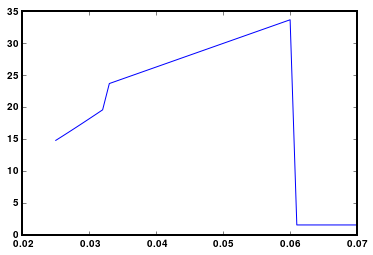

In [1376]:
def get_Ci(n_a):    
    # input atomic number density  unit : 1/m^3
    # output Ci unit : 1/m^3    
    return 1.5*n_a # 1/ m^3

def get_Ci_new(n_a,Ti):
    
    # input n_a: 1/m^3
    # input Ti : J
    
    # T : K 
    T = Ti/eV/kelvin_to_eV
    
    #print(T)
    
    cp_solid_1 = 7.7551*10**5*T**(-2) + 0.53447*T - 41.58
    cp_solid_2 = 0.2653*T + 95.12
        
    if (T>=200) and (T<373)  : Ci = cp_solid_1*J_per_mole_per_K*n_a
        
    if (T>=373) and (T<700) : Ci = cp_solid_2*J_per_mole_per_K*n_a

    if (T>=700) : Ci = 1.5*n_a
    
    return Ci

if 1 :
    temp = [ T for T in np.arange(0.025,.07,.001)]
    Ci_new = np.array([ get_Ci_new(n_a_CH,T*eV) for T in temp ])
    plt.plot(temp,Ci_new/n_a_CH)

## get_G

In [1378]:
def get_G(Ce,vc,Ti):
    
    # input collision frequency unit : 1/s
    # input Ce unit : 1/m^3 
    # output G unit : 1/m^3/s
    
    mS = (12+1)*8*amu
    mB = (12+1)*6*amu  
    mA = (12+1)*2*amu
    mCH = (12+1)/2*amu
    mC = 12*amu
    mH = 1*amu    
    
    if (Ti < 2.32*eV)  : mil = mH # (mS + mC + mH)/3
    if (Ti >= 2.32*eV) and (Ti < 2.43*eV) : mil = (mS+mB+mA)/3
    if (Ti >= 2.43*eV) and (Ti < 4.00*eV) : mil = mB
    if (Ti >= 4.00*eV) and (Ti < 8.00*eV) : mil = (mB+mA+mCH)/3
    if (Ti >= 8.00*eV) : mil = mCH
        
    me_to_mil = massElectron/mil
    
    #me_to_mil = 1/1836
    
    return Ce*vc*me_to_mil # 1/m^3/s

## get_n

In [866]:
def get_n(n_IN,omega_IN):
    
    # input n_IN : 1/m^3
    # input omega_IN : 1/s
    
    n_CGS = n_IN/100**3 # 1/cm^3
    
    omega_pe = np.sqrt(4*np.pi*n_CGS*eCharge_CGS**2/massElectron_CGS) # 1/s
    
    RefractiveIndex = np.sqrt(1-(omega_pe/omega_IN)**2) # unitless
    
    return RefractiveIndex # unitless

## get_JH

In [867]:
def get_JH(n_fe,vc,omega,laserE,RefractiveIndex):
    
    # input eCharge unit : Coulomb
    # input n_fe    unit : 1/m^3 
    # input vc      unit : 1/s
    # input massElectron unit : kg
    # input omega unit : 1/s
    # input laserE unit : V/m
    # input lightSpeed unit : m/s
    # input vacuumPermittivity unit : # C⋅V−1⋅m−1
    
    # output dUdt  unit : 1/m^3/s   
    # output sigma unit : 1/m
    
    dUdt  = eCharge**2*n_fe*vc/massElectron/(omega**2+vc**2)*laserE**2         # J/s/m^3
    #sigma = dUdt/(laserE**2)*2/(lightSpeed*RefractiveIndex*vacuumPermittivity) # 1/m
    sigma = dUdt/(laserE**2)/(lightSpeed*RefractiveIndex*vacuumPermittivity) # 1/m
    #sigma = vc/(RefractiveIndex*lightSpeed)
    return [dUdt,sigma]

## get_vr

In [1253]:
def get_vr(ne,Te):
    
    # ne : 1/m^3
    # Te : J
    
    Te_eV = Te/eV      # eV
    ne_gcc = ne/100**3 # 1/cm^3
    
    tr = 1.8*10**26*Te_eV**4.5/ne_gcc**2 # s

    vr = 1/tr # 1/s
    
    return vr
    
print("{:.3e}".format(get_vr(4.5*10**19*100**3,10*eV))   )

3.558e+08


## get_vi

In [1252]:
def get_vi(laserE,omega,Eg,vc):

    # input eCharge unit : Coulomb
    # input vc      unit : 1/s
    # input massElectron unit : kg
    # input omega unit : 1/s
    # input laserE unit : V/m
    # input lightSpeed unit : m/s
    # input vacuumPermittivity unit : # C⋅V−1⋅m−1
    
    vi  = eCharge**2*vc/massElectron/(omega**2+vc**2)*laserE**2/Eg_CH         # J/s
    
    return vi

laserE = get_laserE(laserI=5.7*10**10*100**2,RefractiveIndex=1)

print("{:.3e}".format(get_vi(laserE,omega_355nm,Eg_CH,10**15)))

6.406e+11


## get_main

In [1584]:
Thickness = 30 # um
Nz = int(Thickness*um/wavelength_355nm)
dz = wavelength_355nm # m
dt = dz/lightSpeed*10 # s

laserI_probe_INC = probe_intensity # W/m^2 # laser intensity of probe pulse
alpha        = 10**(14)  # 1/s # rate of impact ionization
taur         = 10**(-12)*1000 # s   # electron recombination
nc_355nm     = get_nc(wavelength_355nm) # (1/m^3)
nc_450nm     = get_nc(wavelength_450nm) # (1/m^3)

Ns_zone  = 6
Ns_edge  = 4
var_zone = np.zeros([Nz,Ns_zone])

n_0 = 10**10*100**3 # 1/m^3 
n_1 = 0             # 1/m^3 
n_2 = 0             # 1/m^3 
Te  = 0.025*eV # J
Ti  = 0.025*eV # J

var_zone[:,0] = n_0 # 1/m^3 
var_zone[:,1] = n_1 # 1/m^3 
var_zone[:,2] = n_2 # 1/m^3
var_zone[:,3] = Te  # J
var_zone[:,4] = Ti  # J

t_start_wall = timeCheck.time()
hist         = []

pulse_IN = pulse_2
pulse_IN_Imax_TimePs = pulse_2_Imax_TimePs

time         = 0                         # s
time_step    = 0
for time_step in range(pulse_IN.shape[0]*1):
    
    laserI_INC   = pulse_IN[time_step,1]      # W/m^2
    laserE_INC   = get_laserE(laserI_INC,1)   # V/m with RefractiveIndex = 1
    time_current = pulse_IN[time_step,0]*ns   # s
    time_next    = pulse_IN[time_step+1,0]*ns # s
    ite_max      = int((time_next - time_current)/dt)
    
    ne_IN  = sum(var_zone[0,0:2])  # 1/m^3
    ne_OUT = sum(var_zone[-1,0:2]) # 1/m^3
    n_IN     = get_n(ne_IN,omega_355nm)  # unitless
    n_OUT    = get_n(ne_OUT,omega_355nm) # unitless 
    Te_IN    = var_zone[0,3]  # J
    Te_OUT   = var_zone[-1,3] # J 
    Ti_IN    = var_zone[0,4]  # J
    Ti_OUT   = var_zone[-1,4] # J     
    vc_IN    = get_vc_new(Te_IN,Ti_IN,ne_IN,n_a_CH,R_CH)   # 1/s
    vc_OUT   = get_vc_new(Te_OUT,Ti_OUT,ne_OUT,n_a_CH,R_CH)# 1/s    
    dU_IN, si_IN   = get_JH(ne_IN,vc_IN,omega_355nm,laserE,n_IN)
    dU_OUT, si_OUT = get_JH(ne_OUT,vc_OUT,omega_355nm,laserE,n_OUT) 
    Z_IN  = ne_IN/n_a_CH
    Z_OUT = ne_OUT/n_a_CH
    Z_QMD_IN  = get_Zeff(n_a_CH,Te_IN)
    Z_QMD_OUT = get_Zeff(n_a_CH,Te_OUT)

    print('time_step    = ',time_step)    
    print('time         = ',"{:.3e}".format(time/ps),' ps')
    print('time_current = ',"{:.3e}".format(time_current/ps),' ps')
    print('time_next    = ',"{:.3e}".format(time_next/ps),' ps')
    print('dt           = ',"{:.3e}".format(dt),' s')
    print('Te_IN, Te_OUT = ',"{:.3e}".format(Te_IN/eV),"{:.3e}".format(Te_OUT/eV),'eV')
    print('Ti_IN, Ti_OUT = ',"{:.3e}".format(Ti_IN/eV),"{:.3e}".format(Ti_OUT/eV),'eV') 
    print('ne_IN, ne_OUT = ',"{:.3e}".format(ne_IN),"{:.3e}".format(ne_OUT),'1/m^3')
    print('vc_IN, vc_OUT = ',"{:.3e}".format(vc_IN),"{:.3e}".format(vc_OUT),'1/s')
    print('dU_IN, dU_OUT = ',"{:.3e}".format(dU_IN),"{:.3e}".format(dU_OUT),'J/s/m^3') 
    print('si_IN, si_OUT = ',"{:.3e}".format(si_IN),"{:.3e}".format(si_OUT),'1/m') 
    print('Z_IN,  Z_OUT  = ',"{:.3e}".format(Z_IN),"{:.3e}".format(Z_OUT)) 
    print('Z_QMD_IN,Z_QMD_OUT = ',"{:.3e}".format(Z_QMD_IN),"{:.3e}".format(Z_QMD_OUT))
    print('Te_max        = ',"{:.3e}".format(max(var_zone[:,3])/eV),'eV')
    print('Ti_max        = ',"{:.3e}".format(max(var_zone[:,4])/eV),'eV')    
    print('ite_max       = ',ite_max)    

    for ite in range(ite_max):
        
        n_fe_max = np.max(var_zone[:,0]+var_zone[:,1]+var_zone[:,2]) # 1/m^3
        Te_max   = np.max(var_zone[:,3]) # J
        Ti_max   = np.max(var_zone[:,4]) # J

        laserI        = laserI_INC       # W/m^2     
        laserI_probe  = laserI_probe_INC # W/m^2
        laserE        = laserE_INC       # V/m   
        var_edge      = np.zeros([Nz+1,Ns_edge])
        var_edge[0,0] = 0      # m
        var_edge[0,1] = laserI # W/m^2
        var_edge[0,2] = laserE # V/m
        var_edge[0,3] = laserI_probe # W/m^2
        
        if 0 : 
            print()
            print('ite, time, n_fe_max, transimittance = ',
                  ite,
                  "{:.3e}".format(time),
                  "{:.3e}".format(n_fe_max),
                  "{:.3e}".format(laserI_probe/laserI_probe_INC),
                  "{:.3e}".format(laserI/laserI_INC))
            print('---')        

        for zone in range(1,Nz+1):
            i_zone = zone - 1 
            zp     = zone*dz     # m
            zm     = (zone-1)*dz # m

            n_0 = var_zone[i_zone,0] # 1/m^3
            n_1 = var_zone[i_zone,1] # 1/m^3
            n_2 = var_zone[i_zone,2] # 1/m^3
            Te  = var_zone[i_zone,3] # J
            Ti  = var_zone[i_zone,4] # J  

            n_fe  = n_0 + n_1 + n_2          # 1/m^3
            beta  = (n_vb_CH - n_fe)/n_vb_CH # no unit
            n_old = [n_0, n_1, n_2]          # 1/m^3   
            #####################################            
            #vc_OLD  = get_vc(Te/eV,Ti/eV,n_fe,n_a_CH,1)               # 1/s
            vc      = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            #vr      = get_vr(n_fe,Te) # 1/s
            #taur    = 1/vr # s
            #alpha   = get_vi(laserE,omega_355nm,Eg_CH,vc) # 1/s
            #####################################
            n       = get_n(n_fe,omega_355nm) # unitless  
            n_probe = get_n(n_fe,omega_450nm) # unitless     
            laserE       = get_laserE(laserI,n)             # V/m         
            laserE_probe = get_laserE(laserI_probe,n_probe) # V/m     
            Nmax      = 50
            WPI       = get_WPI(laserI,laserE,Nmax,omega_355nm,Eg_CH) # 1/(s.m^3)
            W1        = get_W1(laserE) # 1/s
            WPI_probe = get_WPI(laserI_probe,laserE_probe,Nmax,omega_450nm,Eg_CH) #1/(s.m^3)     
            dUdt_JH, sigma_JH       = get_JH(n_fe,vc,omega_355nm,laserE,n)
            dUdt_probe, sigma_probe = get_JH(n_fe,vc,omega_450nm,laserE_probe,n_probe) 
            
            #######################
            # Light Propagation
            #######################     
            dIdz             = - sigma_JH    * laserI       - WPI       * Eg_CH
            dIdz_probe       = - sigma_probe * laserI_probe - WPI_probe * Eg_CH
            laserI_new       = laserI       + dz * dIdz
            laserI_probe_new = laserI_probe + dz * dIdz_probe

            var_edge[zone,0] = zp                       # m
            var_edge[zone,1] = laserI_new               # W/m^2
            var_edge[zone,2] = get_laserE(laserI_new,n) # V/m
            var_edge[zone,3] = laserI_probe_new         # W/m^2 

            #######################
            # Electron Dynamics
            #######################
            source = [beta*WPI,0,0]                             # 1/s/m^3
            row1   = [-1/taur-W1,0,         2*alpha*beta      ] # 1/s
            row2   = [W1        ,-1/taur-W1,0                 ] # 1/s
            row3   = [0,        W1,         -1/taur-alpha*beta] # 1/s
            matrix = [row1, row2, row3]                         # 1/s
            n_new  = n_old + dt * (source + np.dot(matrix,n_old)) # 1/m^3
            n_0_new, n_1_new, n_2_new = n_new       # 1/m^3       
            n_fe_new = n_0_new + n_1_new + n_2_new  # 1/m^3
            dn_fe    = n_fe_new - n_fe              # 1/m^3

            var_zone[i_zone,0] = n_0_new # 1/m^3 
            var_zone[i_zone,1] = n_1_new # 1/m^3 
            var_zone[i_zone,2] = n_2_new # 1/m^3 

            #######################
            # Thermodynamics
            #######################
            #####################################
            #vc =  get_vc(Te,Ti,n_fe_new,n_a_CH,1) # 1/s 
            vc = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            #print('ite,vc = ',ite,vc)
            #####################################
            dUdt_JH, sigma_JH = get_JH(n_fe_new,vc,omega_355nm,laserE,n)
            Ce = get_Ce(n_fe_new) # 1/m^3
            Ci = get_Ci_new(n_a_CH,Ti)   # 1/m^3 
            G  = get_G(Ce,vc,Ti)     # 1/m^3/s
            #if Te <  Tc : G  = get_G(Ce,vc,'solid')     # 1/m^3/s
            #if Te >= Tc : G  = get_G(Ce,vc,'plasma')    # 1/m^3/s
            Qi = G*(Te-Ti)                             # J/s/m^3
            Qe = dUdt_JH - 1.5*Te*dn_fe/dt - G*(Te-Ti) # J/s/m^3            
            Te_new = Te + Qe*dt/Ce # eV
            Ti_new = Ti + Qi*dt/Ci # eV     

            var_zone[i_zone,3] = Te_new  # eV
            var_zone[i_zone,4] = Ti_new  # eV 

            laserI       = laserI_new
            laserI_probe = laserI_probe_new

            if (n_0_new < 0) or (n_1_new < 0) or (n_2_new < 0) :
                print('negative n_0, n_1, n_2 detected, STOP')
                break

            if (Te_new < 0) or (Ti_new < 0) :
                print('negative Te, Ti detected, STOP')
                print('Qe = ',Qe)
                break 

            if (laserI_new < 0) or (laserI_probe_new < 0) :
                print('negative laserI, laserI_probe detected, STOP')
                break 

            if (n_fe_new > nc_355nm) or (n_fe_new > nc_450nm) :
                print('negative n_fe exceed nc detected, STOP')
                break             

            #print(zone,laserI/laserI_INC)
            #print(zone,"{:.3e}".format(laserI_probe),"{:.3e}".format(laserI_probe_INC))
            #print(zone,laserI,laserI_new,laserI_probe,laserI_probe_new)
            #print(zone,"{:.3e}".format(n_0_new),"{:.3e}".format(n_1_new),"{:.3e}".format(n_2_new),
            #      ' : ',"{:.3e}".format(n_0),"{:.3e}".format(n_1),"{:.3e}".format(n_2))
            #print(zone,time,Te_new,Ti_new,' : ',Te,Ti)
            #print(zone,"{:.3e}".format(zp),"{:.3e}".format(time))
            
        time = time + dt
                    
    sol = [ne_IN,#0
           ne_OUT,#1
           n_IN,#2
           n_OUT,#3
           Te_IN,#4
           Te_OUT,#5
           vc_IN,#6
           vc_OUT,#7
           dU_IN,#8
           dU_OUT,#9
           si_IN,#10
           si_OUT,#11
           Ti_IN,#12
           Ti_OUT,#13 
           Z_IN,#14
           Z_OUT,#15
           Z_QMD_IN,#16
           Z_QMD_OUT#17           
          ]
        
    hist.append([time,#0
                 laserI_probe/laserI_probe_INC,#1
                 laserI/laserI_INC,#2
                 var_zone,#3
                 var_edge,#4
                 sol#5
                ])
        
    t_end_wall = timeCheck.time()
    print('Ray propagation completed in time_step : ',time_step)    
    print('t_end_wall - t_start_wall = ',int((t_end_wall-t_start_wall)/60),' minutes')
    print('time_ps,transimittance for probe and pump = ',
          "{:.3e}".format(time_current/ps-pulse_IN_Imax_TimePs),
          "{:.3e}".format(laserI_probe/laserI_probe_INC),
          "{:.3e}".format(laserI/laserI_INC))
    print('---')      
    
hist = np.array(hist)    

time_step    =  0
time         =  0.000e+00  ps
time_current =  0.000e+00  ps
time_next    =  5.000e+00  ps
dt           =  1.184e-14  s
Te_IN, Te_OUT =  2.500e-02 2.500e-02 eV
Ti_IN, Ti_OUT =  2.500e-02 2.500e-02 eV
ne_IN, ne_OUT =  1.000e+16 1.000e+16 1/m^3
vc_IN, vc_OUT =  1.486e+15 1.486e+15 1/s
dU_IN, dU_OUT =  1.601e+07 1.601e+07 J/s/m^3
si_IN, si_OUT =  5.196e-06 5.196e-06 1/m
Z_IN,  Z_OUT  =  9.804e-14 9.804e-14
Z_QMD_IN,Z_QMD_OUT =  2.047e-97 2.047e-97
Te_max        =  2.500e-02 eV
Ti_max        =  2.500e-02 eV
ite_max       =  422
Ray propagation completed in time_step :  0
t_end_wall - t_start_wall =  23  minutes
time_ps,transimittance for probe and pump =  -1.150e+02 9.967e-01 1.000e+00
---
time_step    =  1
time         =  4.997e+00  ps
time_current =  5.000e+00  ps
time_next    =  1.000e+01  ps
dt           =  1.184e-14  s
Te_IN, Te_OUT =  2.054e-02 2.054e-02 eV
Ti_IN, Ti_OUT =  2.500e-02 2.500e-02 eV
ne_IN, ne_OUT =  3.915e+16 3.915e+16 1/m^3
vc_IN, vc_OUT =  1.424e+15 1

Ray propagation completed in time_step :  11
t_end_wall - t_start_wall =  232  minutes
time_ps,transimittance for probe and pump =  -6.000e+01 9.572e-01 9.620e-01
---
time_step    =  12
time         =  5.997e+01  ps
time_current =  6.000e+01  ps
time_next    =  6.500e+01  ps
dt           =  1.184e-14  s
Te_IN, Te_OUT =  1.694e+00 1.645e+00 eV
Ti_IN, Ti_OUT =  2.501e-02 2.501e-02 eV
ne_IN, ne_OUT =  1.900e+24 1.814e+24 1/m^3
vc_IN, vc_OUT =  1.324e+15 1.332e+15 1/s
dU_IN, dU_OUT =  6.539e+17 6.276e+17 J/s/m^3
si_IN, si_OUT =  8.929e+02 8.570e+02 1/m
Z_IN,  Z_OUT  =  1.863e-05 1.778e-05
Z_QMD_IN,Z_QMD_OUT =  2.785e-04 2.482e-04
Te_max        =  1.694e+00 eV
Ti_max        =  2.501e-02 eV
ite_max       =  422
Ray propagation completed in time_step :  12
t_end_wall - t_start_wall =  247  minutes
time_ps,transimittance for probe and pump =  -5.500e+01 9.108e-01 9.271e-01
---
time_step    =  13
time         =  6.496e+01  ps
time_current =  6.500e+01  ps
time_next    =  7.000e+01  ps
dt       

Ray propagation completed in time_step :  23
t_end_wall - t_start_wall =  410  minutes
time_ps,transimittance for probe and pump =  1.421e-14 1.920e-01 3.422e-01
---
time_step    =  24
time         =  1.199e+02  ps
time_current =  1.200e+02  ps
time_next    =  1.250e+02  ps
dt           =  1.184e-14  s
Te_IN, Te_OUT =  6.133e+00 2.335e+00 eV
Ti_IN, Ti_OUT =  3.175e-02 2.738e-02 eV
ne_IN, ne_OUT =  1.416e+26 4.883e+25 1/m^3
vc_IN, vc_OUT =  1.158e+15 1.294e+15 1/s
dU_IN, dU_OUT =  4.902e+19 1.867e+19 J/s/m^3
si_IN, si_OUT =  5.952e+04 2.255e+04 1/m
Z_IN,  Z_OUT  =  1.388e-03 4.787e-04
Z_QMD_IN,Z_QMD_OUT =  7.791e-03 8.387e-04
Te_max        =  6.133e+00 eV
Ti_max        =  3.175e-02 eV
ite_max       =  422
Ray propagation completed in time_step :  24
t_end_wall - t_start_wall =  424  minutes
time_ps,transimittance for probe and pump =  5.000e+00 1.381e-01 2.777e-01
---
time_step    =  25
time         =  1.249e+02  ps
time_current =  1.250e+02  ps
time_next    =  1.300e+02  ps
dt         

IndexError: index 36 is out of bounds for axis 0 with size 36

# Data

## get_save_data

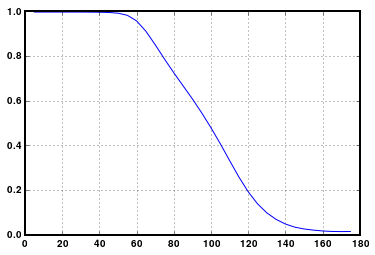

Save as                        : pulse_2_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_Zeff_VCneutral_TCnew_CInew
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


In [1585]:
def get_save_data(exportFlag):
    
    if exportFlag : 
        export_name = 'pulse_2_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_Zeff_VCneutral_TCnew_CInew'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        np.savetxt(export_name+'.csv', data, delimiter=",")
            
data = []
for ele in hist:
    ele = np.array(ele)
    #print(ele[0],ele[1])
    if ele[1]>0 : data.append([ele[0]/ps,#0
                               ele[1],#1
                               ele[2],#2
                               ele[5][0],#3 ne_IN,#0
                               ele[5][1],#4 ne_OUT,#1
                               ele[5][2],#5 n_IN,#2
                               ele[5][3],#6 n_OUT,#3
                               ele[5][4],#7 Te_IN,#4
                               ele[5][5],#8 Te_OUT,#5
                               ele[5][6],#9 vc_IN,#6
                               ele[5][7],#10 vc_OUT,#7
                               ele[5][8],#11 dU_IN,#8
                               ele[5][9],#12 dU_OUT,#9
                               ele[5][10],#13 si_IN,#10
                               ele[5][11],#14 si_OUT#11
                               ele[5][12],#15 Ti_IN,#12
                               ele[5][13],#16 Ti_OUT#13
                               ele[5][14],#17 Z_IN,#14
                               ele[5][15],#18 Z_OUT#15  
                               ele[5][16],#19 ZQMD_IN,#16
                               ele[5][17]#20 ZQMD_OUT#17
                              ])
data = np.array(data)
plt.plot(data[:,0],data[:,1])
plt.grid()              
plt.show()              
              
get_save_data(exportFlag=1)

## get_open_data_exp

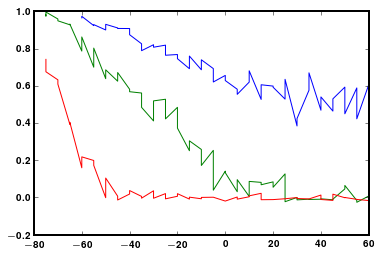

In [1566]:
def get_open_data_exp(file_name):
    
    output = []
    file_to_open = open(file_name,'r')
    for line in file_to_open :
        row = line.split('\t')
        tmp = [ float(ele) for ele in row ]
        #print(tmp)
        output.append(tmp)
    return np.array(output)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/Suxing/'
file_name_1 = 'pulse_1_transmittance_new.csv' 
file_name_2 = 'pulse_2_transmittance_new.csv' 
file_name_3 = 'pulse_3_transmittance_new.csv' 
dat_1_exp = get_open_data_exp(path+file_name_1) 
dat_2_exp = get_open_data_exp(path+file_name_2) 
dat_3_exp = get_open_data_exp(path+file_name_3) 

plt.plot(dat_1_exp[:,0],dat_1_exp[:,1])
plt.plot(dat_2_exp[:,0],dat_2_exp[:,1])
plt.plot(dat_3_exp[:,0],dat_3_exp[:,1])

## get_open_data_sim

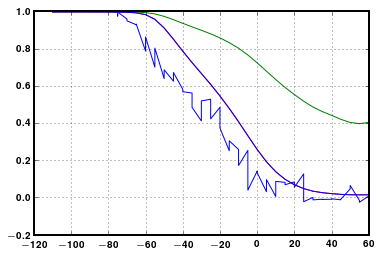

In [1587]:
def get_open_data_sim(file_name):
    
    output = []
    file_to_open = open(file_name,'r')
    for line in file_to_open :
        row = line.split(',')
        tmp = [ float(ele) for ele in row ]
        #print(tmp)
        output.append(tmp)
    return np.array(output)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_vcSolidPhase10xLarger_WPI2xLower_vr1000xLower_JHnew.csv'  
dat_1 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_2_transmittance_pump_vcSolidPhase10xLarger_WPI2xLower_vr1000xLower_JHnew.csv'  
dat_2 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_3_transmittance_pump_vcSolidPhase10xLarger_WPI2xLower_vr1000xLower_JHnew.csv'  
dat_3 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump__WPI2xLower_vr1000xLower_JHnew_oldVCwithCorrectNEunit.csv' 
dat_4 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump__WPI2xLower_vr1000xLower_JHnew_VCnew.csv'
dat_5 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPIunchanged_vr1000xLower_JHnew_VCnew.csv'
dat_6 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPIunchanged_vr1000xLower_JHnew_VCnew_vmfp.csv'
dat_7 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPIunchanged_vr2000xLower_JHnew_VCnew_vmfp.csv'
dat_8 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr10000xLower_JHnew_VCnew.csv'
dat_9 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnew_VCionE6Larger.csv'
dat_10 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnewPhonon_VCionE6Larger.csv'
dat_11 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnewPhonon_VCionE1Larger.csv'
dat_12 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnewPhonon_VCionZeff.csv'
dat_13 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr10000xLarger_JHnew_VCnewPhonon_VCionZeff.csv'
dat_14 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr10000xLarger_JHnew_VCnewPhonon_VCionZeff_VCneutral.csv'
dat_15 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VPhonon_VCionZeff_VCneutral_VrVinew.csv'
dat_16 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCionZeff_VCneutral_Gnew_TCnew.csv'
dat_17 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCionZeff_VCneutral_TCnew.csv'
dat_18 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCionZeff_VCneutral_TCnew_GmilMix.csv'
dat_19 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCZeff_VCneutral_TCnew_CInew.csv'
dat_20 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_QMDZeff_VCneutral_TCnew_CInew.csv'
dat_21 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_2_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_QMDZeff_VCneutral_TCnew_CInew.csv'
dat_22 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_2_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_Zeff_VCneutral_TCnew_CInew.csv'
dat_23 = get_open_data_sim(path+file_name)

#plt.plot(dat_1_exp[:,0],dat_1_exp[:,1])
plt.plot(dat_2_exp[:,0],dat_2_exp[:,1])
#plt.plot(dat_3_exp[:,0],dat_3_exp[:,1])
#plt.plot(dat_1[:,0]-pulse_1_Imax_TimePs,dat_1[:,1])
#plt.plot(dat_4[:,0]-pulse_1_Imax_TimePs,dat_4[:,1])
#plt.plot(dat_5[:,0]-pulse_1_Imax_TimePs,dat_5[:,1])
#plt.plot(dat_6[:,0]-pulse_1_Imax_TimePs,dat_6[:,1])
#plt.plot(dat_7[:,0]-pulse_1_Imax_TimePs,dat_7[:,1])
#plt.plot(dat_8[:,0]-pulse_1_Imax_TimePs,dat_8[:,1],ls='dashed')
#plt.plot(dat_9[:,0]-pulse_1_Imax_TimePs,dat_9[:,1],ls='dashed')
#plt.plot(dat_10[:,0]-pulse_1_Imax_TimePs,dat_10[:,1])
#plt.plot(dat_11[:,0]-pulse_1_Imax_TimePs,dat_11[:,1])
#plt.plot(dat_12[:,0]-pulse_1_Imax_TimePs,dat_12[:,1])
#plt.plot(dat_13[:,0]-pulse_1_Imax_TimePs,dat_13[:,1])
#plt.plot(dat_14[:,0]-pulse_1_Imax_TimePs,dat_14[:,1],ls='dashed')
#plt.plot(dat_15[:,0]-pulse_1_Imax_TimePs,dat_15[:,1],c='k')
#plt.plot(dat_16[:,0]-pulse_1_Imax_TimePs,dat_16[:,1],c='r')
#plt.plot(dat_17[:,0]-pulse_1_Imax_TimePs,dat_17[:,1],c='r')
#plt.plot(dat_18[:,0]-pulse_1_Imax_TimePs,dat_18[:,1],c='r')
#plt.plot(dat_19[:,0]-pulse_1_Imax_TimePs,dat_19[:,1],c='g')
#plt.plot(dat_20[:,0]-pulse_1_Imax_TimePs,dat_20[:,1],c='b')
plt.plot(dat_21[:,0]-pulse_1_Imax_TimePs,dat_21[:,1],c='g')
plt.plot(dat_22[:,0]-pulse_2_Imax_TimePs,dat_22[:,1],c='r')
plt.plot(dat_23[:,0]-pulse_2_Imax_TimePs,dat_23[:,1],c='b')
plt.grid()

## get_report_transmittance

Save as                        : transmittance_pump2_include_phonons_neutrals_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


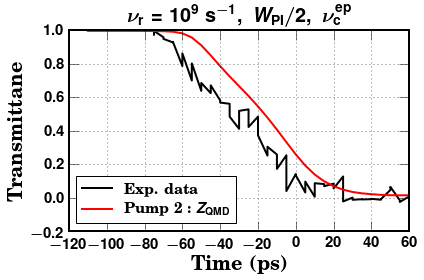

In [1557]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Exp. data}'
    label2 = r'\textbf{Pump 2 : $Z$}'
    label3 = r'\textbf{Pump 2 : $Z_\mathrm{QMD}$}'    

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    #ax1.plot(dat_1_exp[:,0],dat_1_exp[:,1],label=label1,c='k',lw=2)
    ax1.plot(dat_2_exp[:,0],dat_2_exp[:,1],label=label1,c='k',lw=2)    
    #ax1.plot(dat_20[:,0]-pulse_1_Imax_TimePs,dat_20[:,1],label=label2,c='b',lw=2)
    ax1.plot(data[:,0]-pulse_2_Imax_TimePs,data[:,1],label=label3,c='r',lw=2)    

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{Transmittane}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='lower left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_absorptionCoef

Save as                        : transmittance_pump2_include_phonons_neutrals_absorptionCoef_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


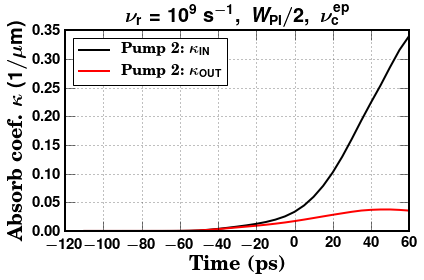

In [1568]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $\kappa_{\mathrm{IN}}$}'
    label2 = r'\textbf{Pump 2: $\kappa_{\mathrm{OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,13]/10**6,label=label1,c='k',lw=2)  
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,14]/10**6,label=label2,c='r',lw=2)    

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{Absorb coef. $\kappa ~\mathrm{(1/\mu m)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_absorptionCoef_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_te

Save as                        : transmittance_pump2_include_phonons_neutrals_Te_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


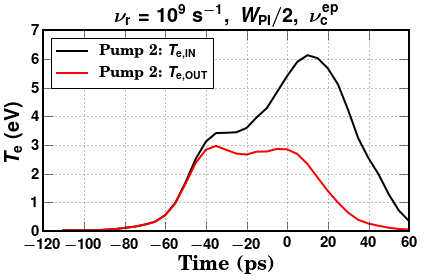

In [1569]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $T_{\mathrm{e,IN}}$}'
    label2 = r'\textbf{Pump 2: $T_{\mathrm{e,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,7]/eV,label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,8]/eV,label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$T_{\mathrm{e}} ~\mathrm{(eV)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Te_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_ti

Save as                        : transmittance_pump2_include_phonons_neutrals_Ti_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


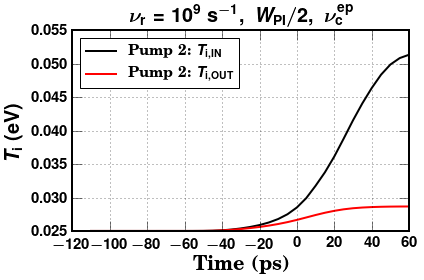

In [1570]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $T_{\mathrm{i,IN}}$}'
    label2 = r'\textbf{Pump 2: $T_{\mathrm{i,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,15]/eV,label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,16]/eV,label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$T_{\mathrm{i}} ~\mathrm{(eV)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Ti_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_vc

Save as                        : transmittance_pump2_include_phonons_neutrals_Vc_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


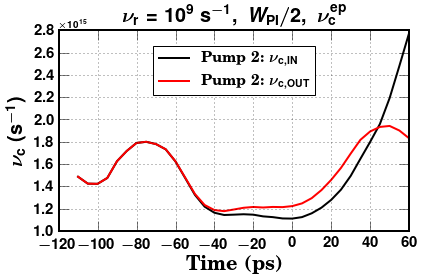

In [1571]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $\nu_{\mathrm{c,IN}}$}'
    label2 = r'\textbf{Pump 2: $\nu_{\mathrm{c,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,9],label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,10],label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$\nu_{\mathrm{c}} ~\mathrm{(s^{-1})}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='center',bbox_to_anchor=[0.5,0.8],numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Vc_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_ne

Save as                        : transmittance_pump2_include_phonons_neutrals_Ne_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


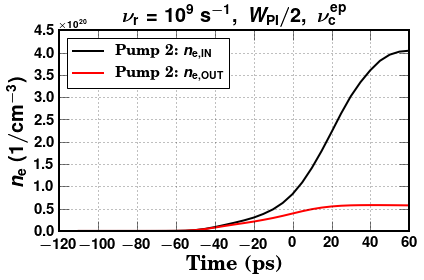

In [1572]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $n_{\mathrm{e,IN}}$}'
    label2 = r'\textbf{Pump 2: $n_{\mathrm{e,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,3]/100**3,label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,4]/100**3,label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$n_{\mathrm{e}} ~\mathrm{(1/cm^{-3})}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Ne_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_JH

Save as                        : transmittance_pump2_include_phonons_neutrals_dUdt_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


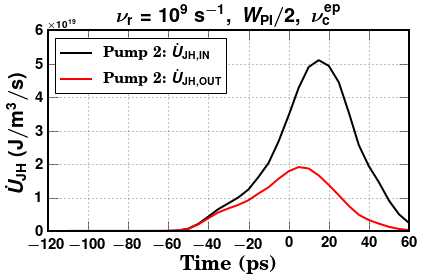

In [1573]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $\dot{U}_{\mathrm{JH,IN}}$}'
    label2 = r'\textbf{Pump 2: $\dot{U}_{\mathrm{JH,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,11],label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,12],label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$\dot{U}_{\mathrm{JH}} ~\mathrm{(J/m^3/s)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_dUdt_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_Z

Save as                        : transmittance_pump2_include_phonons_neutrals_Z_Tc_Ci_Zqmd
path_local                     : /Users/kwoo/Desktop/PostDoc/InitialPlasma/python
path_save                      : /Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/


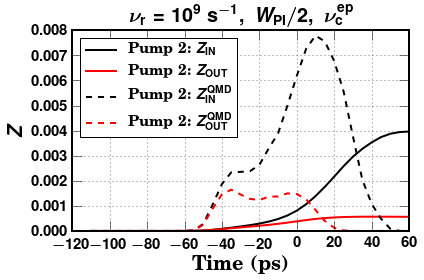

In [1565]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $Z_{\mathrm{IN}}$}'
    label2 = r'\textbf{Pump 2: $Z_{\mathrm{OUT}}$}'
    label3 = r'\textbf{Pump 2: $Z_{\mathrm{IN}}^{\mathrm{QMD}}$}'
    label4 = r'\textbf{Pump 2: $Z_{\mathrm{OUT}}^{\mathrm{QMD}}$}'    

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,17],label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,18],label=label2,c='r',lw=2)
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,19],label=label3,c='k',lw=2,ls='dashed')    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,20],label=label4,c='r',lw=2,ls='dashed')    

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$Z$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Z_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)